# Frame by Frame: The Kaleidoscopic Evolution of Cinema Over the Decades

In [19]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import xml.etree.ElementTree as ET
import time
import json
import statsmodels.formula.api as smf
from utilities import * 
import tarfile
import math
import gzip
import os

from data_preprocessing import * 
from imdb_ratings_scraper import *
import load_functions as lf
import complexity as cx

import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models
import pickle

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

## Movie Summaries

In [4]:
data_folder = './data/MovieSummaries/'
(movie_metadata, character_metadata, name_clusters, plot_summaries, test_data) = \
    lf.load_movie_summaries(data_folder)

# add release year (float) to movie_metadata, extracting it from release_date
movie_metadata['release_year'] = movie_metadata['release_date'].apply(lambda x: lf.extract_year(x))
# add lowecase title to movie_metadata
movie_metadata['lowercase_title'] = movie_metadata['movie_name'].str.lower()

# add release year (float) to character_metadata, extracting it from release_date
character_metadata['release_year'] = character_metadata['release_date'].apply(lambda x: lf.extract_year(x))
# add actor birth year (float) to character_metadata, extracting it from actor_birth_date
character_metadata['actor_birth_year'] = character_metadata['actor_birth_date'].apply(lambda x: lf.extract_year(x))

Metadata for 81 741 movies, extracted from the Noverber 4, 2012 dump of Freebase:
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)
10. Movie release year
11. Lowercase title

In [5]:
movie_metadata.head(1)

,wiki_movie_id,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres,release_year,lowercase_title
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,ghosts of mars


Metadata for 450 669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase:
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID
14. Release year
15. Actor birth year

In [6]:
character_metadata.head(1)

,wiki_movie_id,free_movie_id,release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,free_character_actor_map_id,free_character_id,free_actor_id,release_year,actor_birth_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001.0,1958.0


Plot summaries of 42 303 movies extracted from the November 2, 2012 dump of English-language Wikipedia.
Each line contains the Wikipedia movie ID (which indexes into movie_metadata) followed by the summary.

In [8]:
plot_summaries.head()

,wiki_movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


# Basic features analysis

## Undestanding the dataset

In [9]:
print('number of nan values in movie_metadata:')
print(movie_metadata.isna().sum())
print('\nnumber of rows in movie_metadata:',movie_metadata.shape[0])

number of nan values in movie_metadata:
wiki_movie_id             0
free_movie_id             0
movie_name                0
release_date           6902
box_office_revenue    73340
runtime               20450
languages                 0
countries                 0
genres                    0
release_year           6902
lowercase_title           0
dtype: int64

number of rows in movie_metadata: 81741


In [10]:
print('number of nan values in character_metadata:')
print(character_metadata.isna().sum())
print('\nnumber of character_metadata rows:', character_metadata.shape[0])

number of nan values in character_metadata:
wiki_movie_id                       0
free_movie_id                       0
release_date                     9995
character_name                 257875
actor_birth_date               106145
actor_gender                    45609
actor_height                   295845
actor_ethnicity                344611
actor_name                       1228
actor_age                      158113
free_character_actor_map_id         0
free_character_id              257865
free_actor_id                     815
release_year                     9995
actor_birth_year               106156
dtype: int64

number of character_metadata rows: 450669


In [11]:
print('unique values of freebase movie ID in character_metadata:',
      len(character_metadata['free_movie_id'].unique()))
print('freebase movie ID in character_metadata:',
      len(character_metadata['free_movie_id']))
print('number of movie ID in character_metadata, which appear in movie_metadata:',
      sum(movie_metadata['free_movie_id'].isin(character_metadata['free_movie_id'].unique())))

unique values of freebase movie ID in character_metadata: 64330
freebase movie ID in character_metadata: 450669
number of movie ID in character_metadata, which appear in movie_metadata: 64330


Each movie in character_metadata appears in movie_metadata

In [12]:
print('unique values of freebase character ID in character_metadata (number of characters):',
      len(character_metadata['free_character_id'].unique()))
print('unique values of freebase actor ID in character_metadata (number of actors):',
      len(character_metadata['free_actor_id'].unique()))
print('unique values of actor ethnicity in character_metadata (number of ethnicities):',
      len(character_metadata['actor_ethnicity'].unique()))

unique values of freebase character ID in character_metadata (number of characters): 183436
unique values of freebase actor ID in character_metadata (number of actors): 135761
unique values of actor ethnicity in character_metadata (number of ethnicities): 480


## Plot data

### Movies metadata

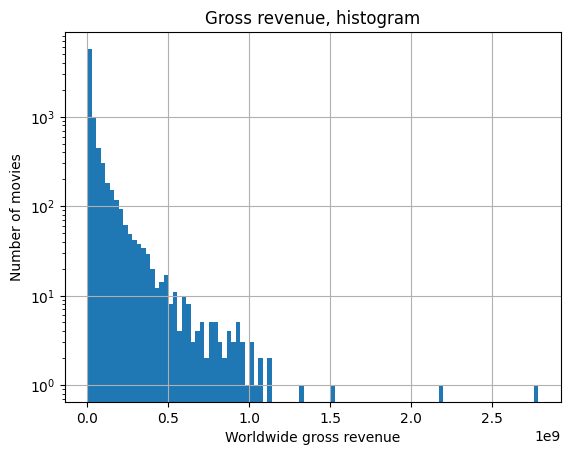

In [13]:
# gross revenue histogram
movie_metadata['box_office_revenue'].dropna().hist(bins = 100, log=True)
plt.xlabel('Worldwide gross revenue')
plt.ylabel('Number of movies')
plt.title('Gross revenue, histogram');

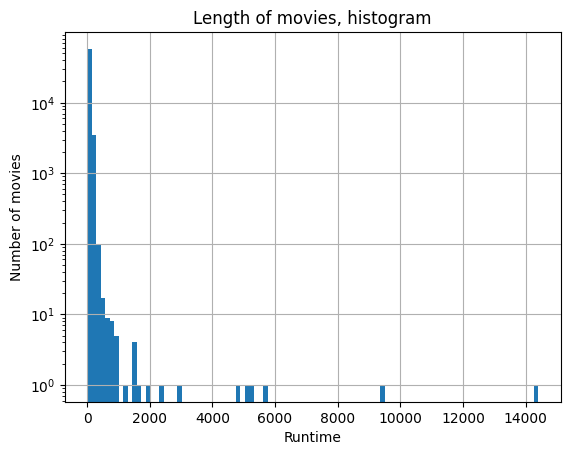

In [14]:
# runtime of movies histogram.
# We dropped movies with a length >= 1079280, as we observed errors in the dataset
movie_metadata[movie_metadata['runtime'] < 1079280].runtime.dropna().hist(bins = 100, log=True)
plt.xlabel('Runtime')
plt.ylabel('Number of movies')
plt.title('Length of movies, histogram');

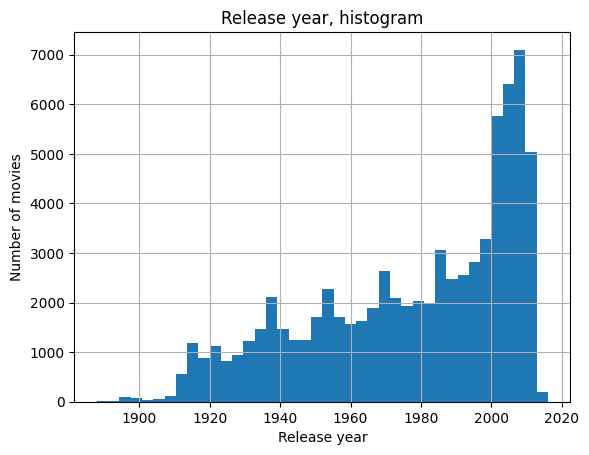

In [15]:
# release year histogram. We dropped movies with a release year <= 1011,
# We dropped movies with a release year <= 1011, as we observed errors in the dataset
movie_metadata[movie_metadata['release_year'] > 1011].release_year.dropna().hist(bins = 40, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of movies')
plt.title('Release year, histogram');

The distribution is very skewed with the big majority of movies after 2000

### Characters metadata

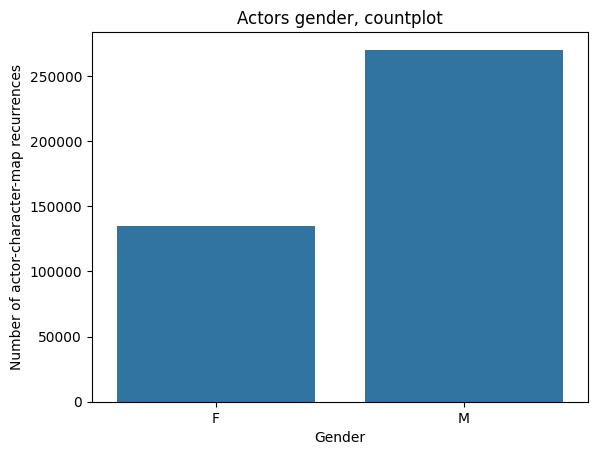

In [16]:
# actor gender countplot
sns.countplot(data=character_metadata, x="actor_gender");
plt.title('Actors gender, countplot')
plt.xlabel('Gender')
plt.ylabel('Number of actor-character-map recurrences');

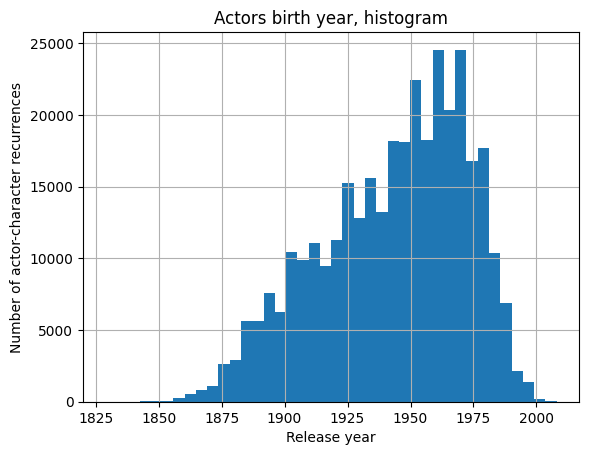

In [17]:
# actor birth year, histogram
# We dropped actors with a birth year <= 1828 or >= 2009, as we observed errors in the dataset
character_metadata[(character_metadata['actor_birth_year'] > 1828) * (character_metadata['actor_birth_year'] < 2009)].actor_birth_year.dropna().hist(bins = 40, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of actor-character recurrences')
plt.title('Actors birth year, histogram');

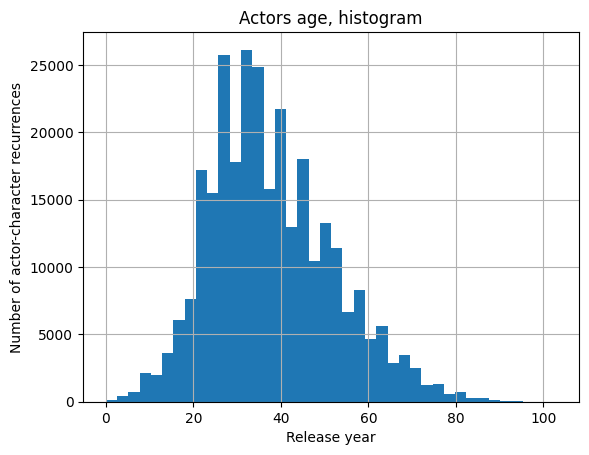

In [18]:
# actor age histogram
# We dropped actors with an age < 0, as we observed errors in the dataset
character_metadata[character_metadata['actor_age'] >= 0].actor_age.dropna().hist(bins = 40, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of actor-character recurrences')
plt.title('Actors age, histogram');

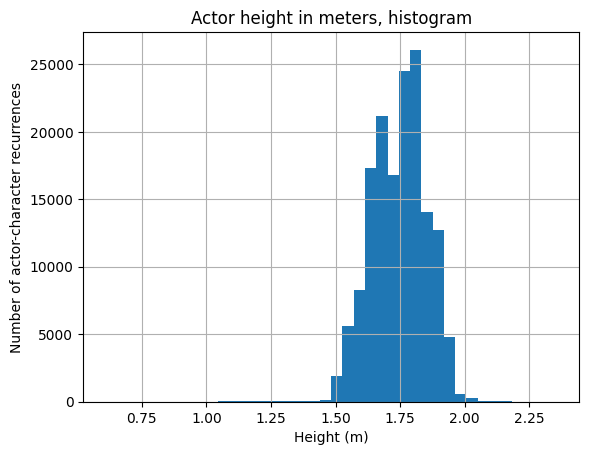

In [19]:
# actor height histogram
# We dropped actors with a height >= 3, as we observed errors in the dataset
character_metadata[character_metadata['actor_height'] < 3].actor_height.dropna().hist(bins = 40, log=False)
plt.xlabel('Height (m)')
plt.ylabel('Number of actor-character recurrences')
plt.title('Actor height in meters, histogram');

# Exploring how characteristic of most popular movies changed over time

In [3]:
# loading the two dataset downloaded from imdb
movies_info = pd.read_csv('data/movies_imdb_ids.csv')
movies_review = pd.read_csv('data/title_ratings_tsv.tsv', sep = '\t')

movies_info_ratings = movies_info.merge(movies_review, how = 'inner', on= 'tconst')
movies_info_ratings['year'] = pd.DatetimeIndex(movies_info_ratings['release date']).year  # extracting year
movies_info_ratings = movies_info_ratings[movies_info_ratings.year < 2012]

In [4]:
# these are the columns we have
movies_info_ratings.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Wikipedia movie ID', 'Freebase movie ID',
       'name', 'release date', 'box office revenue', 'runtime', 'languages',
       'countries', 'genres_x', 'tconst', 'titleType', 'primaryTitle',
       'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes',
       'genres_y', 'averageRating', 'numVotes', 'year'],
      dtype='object')

In this and the following plots we'll only consider the 25 most popular movies for every year. These were selected by ranking movies every year by the number of votes on IMDB. Here we aren’t taking the ratings into account, what we were trying to estimate with this metric is how many people have watched the movie. 

/home/stefano/Documents/EPFL/ada_course/ada-2023-project-msosm/utilities.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='year', y=feature, data=pd.DataFrame(top_25_movies_grouped), ci=95,)


Text(0.5, 1.0, 'Temporal Evolution of Runtimes - Best 25 movies every year')

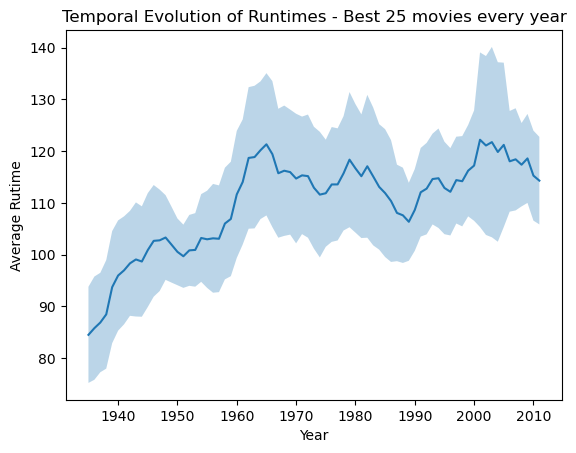

In [39]:
# how did the runtime changed over time? 
plot_25_movies_through_time(movies_info_ratings, 'runtime')
plt.ylabel('Average Rutime')
plt.title('Temporal Evolution of Runtimes - Best 25 movies every year')

Did movies get longer in the last years? They increased until the 60s, than had a small decline until the 90s maybe due to videocassete and other contraints as movies weren't projected only in cinemas anymore. From the 90s onward we see a steady increase probably due to newer technology. 

/home/stefano/Documents/EPFL/ada_course/ada-2023-project-msosm/utilities.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='year', y=feature, data=pd.DataFrame(top_25_movies_grouped), ci=95,)


Text(0.5, 1.0, 'Temporal evolution of IMDB Rating - Best 25 movies every year')

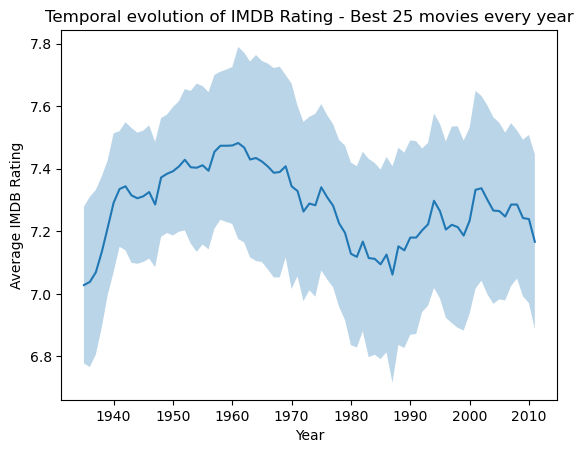

In [43]:
# how did the imdb rating changed for movies published in different years
plot_25_movies_through_time(movies_info_ratings, 'averageRating')
plt.ylabel('Average IMDB Rating')
plt.title('Temporal evolution of IMDB Rating - Best 25 movies every year')

In [5]:
# adjust budget by inflation, dataset taken from https://fred.stlouisfed.org/series/CPIAUCSL

# loading movies' budget
metadata_df = pd.read_csv('data/movies.csv')

# joining with previous dataframe
metadata_df.name = metadata_df.name.str.lower()
movies_info_ratings.name = movies_info_ratings.name.str.lower()
movies_info_ratings_merged = metadata_df.merge(movies_info_ratings, 'inner', on=['name', 'year'])

cpi_over_time = pd.read_csv('data/CPIAUCSL.csv')
# compute the inflation rate for every year compared to today
cpi_over_time['adjustment'] = cpi_over_time['CPIAUCSL'].iloc[-1] / cpi_over_time['CPIAUCSL']
cpi_over_time['date'] = pd.to_datetime(cpi_over_time.DATE, utc=True)
cpi_over_time['year'] = cpi_over_time['date'].apply(lambda x : x.year)
# group the inflation rate per year
cpi_over_time = cpi_over_time.groupby('year').mean()

# merge with previously loaded dataset
importance_over_time_df_adjusted = movies_info_ratings_merged.merge(cpi_over_time, 'inner', on='year').copy()
# multiply the budget by inflation rate in order to get inflation adjusted budget
importance_over_time_df_adjusted['adjusted_budget'] = importance_over_time_df_adjusted.adjustment *  importance_over_time_df_adjusted.budget
# same for box office revenue
importance_over_time_df_adjusted['adjusted_box_office_revenue'] = importance_over_time_df_adjusted.adjustment *  importance_over_time_df_adjusted['box office revenue']

/tmp/ipykernel_21828/4227768411.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='year', y=feature, data=pd.DataFrame(top_25_movies_grouped), ci=95, ax = axes[1])
/tmp/ipykernel_21828/4227768411.py:47: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='year', y=feature, data=pd.DataFrame(top_25_movies_grouped), ci=95, ax = axes[0])


Text(0.5, 1.0, 'Budget')

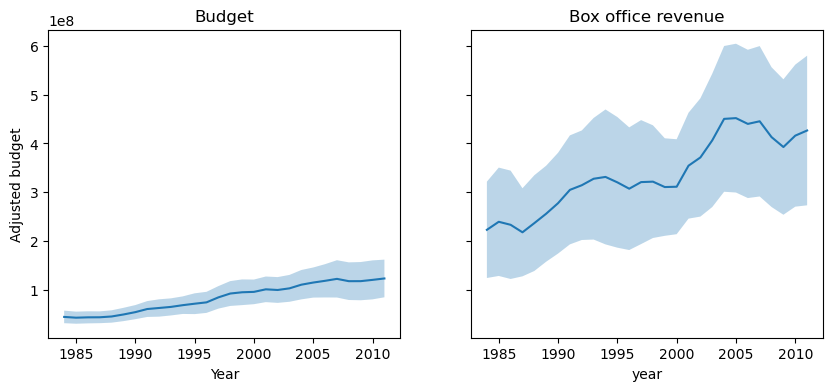

In [7]:
# # how did the average budjet of movies changed through the years? 

f, axes = plt.subplots(1, 2, sharey=True, figsize= (10, 4))

df = importance_over_time_df_adjusted

feature = 'adjusted_box_office_revenue'
# how did the adjusted box office of movies changed through the years? 
sorted_movie_data = df.sort_values(by=['year', 'numVotes'], ascending=[True, False])

# Use groupby to keep the top 25 movies for each year
top_25_movies = sorted_movie_data.groupby('year').head(25)
top_25_movies = top_25_movies[top_25_movies.year > 1930]

window_size = 5
top_25_movies_grouped = top_25_movies.groupby('year').mean()[feature].rolling(window=window_size).mean()
top_25_movies_grouped_std = top_25_movies.groupby('year').std()[feature].rolling(window=window_size).mean()

# Plotting the data with a regression line and confidence interval
sns.lineplot(x='year', y=feature, data=pd.DataFrame(top_25_movies_grouped), ci=95, ax = axes[1])

lower_bound = top_25_movies_grouped - top_25_movies_grouped_std * 1.96 / 5
upper_bound = top_25_movies_grouped + top_25_movies_grouped_std * 1.96  / 5
axes[1].fill_between(top_25_movies_grouped.index, lower_bound, upper_bound, alpha=.3)


axes[1].set_ylabel('Adjusted box office revenue')
plt.title('Box office revenue')



# plot_25_movies_through_time(importance_over_time_df_adjusted, 'adjusted_budget')
feature = 'adjusted_budget'
df = importance_over_time_df_adjusted

sorted_movie_data = df.sort_values(by=['year', 'numVotes'], ascending=[True, False])

# Use groupby to keep the top 25 movies for each year
top_25_movies = sorted_movie_data.groupby('year').head(25)
top_25_movies = top_25_movies[top_25_movies.year > 1930]

window_size = 5
top_25_movies_grouped = top_25_movies.groupby('year').mean()[feature].rolling(window=window_size).mean()
top_25_movies_grouped_std = top_25_movies.groupby('year').std()[feature].rolling(window=window_size).mean()

# Plotting the data with a regression line and confidence interval
sns.lineplot(x='year', y=feature, data=pd.DataFrame(top_25_movies_grouped), ci=95, ax = axes[0])

lower_bound = top_25_movies_grouped - top_25_movies_grouped_std * 1.96 / 5
upper_bound = top_25_movies_grouped + top_25_movies_grouped_std * 1.96  / 5
axes[0].fill_between(top_25_movies_grouped.index, lower_bound, upper_bound, alpha=.3)

axes[0].set_xlabel('Year')
axes[0].set_ylabel('Adjusted budget')
axes[0].set_title('Budget')
# # plt.ylim((1, 6))



/home/stefano/Documents/EPFL/ada_course/ada-2023-project-msosm/utilities.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='year', y=feature, data=pd.DataFrame(top_25_movies_grouped), ci=95,)


Text(0.5, 1.0, 'Temporal evolution of adjusted box office revenue\nBest 25 movies every year')

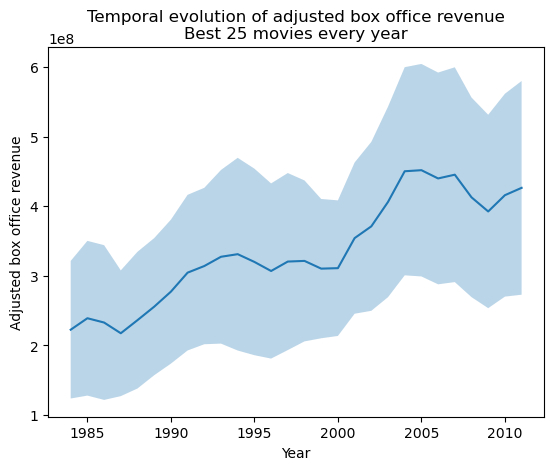

In [46]:
# how did the adjusted box office of movies changed through the years? 
plot_25_movies_through_time(importance_over_time_df_adjusted, 'adjusted_box_office_revenue')
plt.ylabel('Adjusted box office revenue')
plt.title('Temporal evolution of adjusted box office revenue\nBest 25 movies every year')

## Movie topic evolution

In this section, the main goal will be to look at how the topic of movies evolved over time. We will do this by performing Latent Dirichlet Allocation on the whole corpus of movie summaries, to get the different topics of movies and how each movie is distributed over these topics. Then we will split the dataset in different time periods, and look at how the average topic distribution of movies changed over these time periods.

In [ ]:
# Merging the plot summaries with metadata about the movies
plot_summaries = pd.merge(plot_summaries, movie_metadata, on="wiki_movie_id", how='left')


To perform the LDA analysis, we take out only the plot summaries from the dataset and put them in a list. As the order of these plots is preserved throughout this analysis, after getting the topic distribution of each plot, we can easily add back the metadata of movie

In [ ]:
plots = plot_summaries["plot"]
plots_list = list(plots)

### Preprocessing the plot summaries

First, we have to preprocess the textual data. For this purpose we use the spacy library, making use of a natural language model. The major preprocessing steps we use are the following:
- **Tokenization:** We transform the represantation of the plot, currently one long string, into a list of tokens (words, punctuation, ..). Only tokens with alphabetic characters, i.e. regular words, are kept. All other tokens are dropped
- **Named entity recognition:** We also extract all the named entities used in the plot. If these entities are one word person names, like Harry or Emma, we drop them from the list of tokens. This is done because the names of the characters are not significant to the plot. If for example in two very different movies plot-wise, the main character of the movie has the same name, we don't want the LDA to see them as similar because of the same word (the main characters name) occurs a lot in both. However, multi-word named entities, like "New York" were added seperately as "extra tokens".
- **Lemmatization:** Each token is transformed into its base form. Like this occurences of e.g. kill versus kills, have the same influence
- **Casefolding:** All tokens are transformed into their lowercase version.
- **Stopword removal:** Stopwords (very common words) are removed. For this we used a standard list of english stopwords provided by spacy. Furthermore, when doing are analysis, we found that also the words "film" and "tell" were very frequently used in plot summaries and were not really representative of the plot. Therefore these were added to the list of stopwords.
- **Adding bigrams:** We also add bigrams that occur frequently in the corpus, to the list of tokens for each plot.

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
# List of common english stopwords
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
# Adding stopwords specific to our dataset.
STOPWORDS.add("film")
STOPWORDS.add("tell")

processed_plots_1 = list()

# Processing the documents with spacys nlp pipeline
for doc in nlp.pipe(plots_list, n_process=5, batch_size=10):
    
    # Extract all named entities
    ents = doc.ents
    
    # Human names specifically
    people = [ent.text for ent in ents if ent.label_=="PERSON"]
    
    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation, remove stopwords and remove one-word people's names
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and token.text not in people]
    
    # Remove common words from a stopword list, keep only words of length 3 or more and casefolding
    doc = [token.casefold() for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than word.
    doc.extend([str(entity).casefold() for entity in ents if len(entity) > 1])
    
    processed_plots_1.append(doc)


In [ ]:
# Pickling the processed plots so that these preprocessing steps does not have to be repeated every time
with open('processed_plots_1_full.pickle', 'wb') as f:
    pickle.dump(processed_plots_1, f)

In [ ]:
# Adding Bigrams
from gensim.models.phrases import Phrases
import copy

# Load the pickle file containing the plots after the first preprocessing steps
with open('processed_plots_1_full.pickle', 'rb') as f:
         processed_plots_1_full = pickle.load(f)

# Take deep copy to avoid issues when rerunning cell multiple times
processed_plots_2 = copy.deepcopy(processed_plots_1)

# Add bigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(processed_plots_2, min_count=20)

for idx in range(len(processed_plots_2)):
    for token in bigram[processed_plots_2[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            processed_plots_2[idx].append(token)

# Again pickle to avoid having to redo this step!
with open('processed_plots_2_full.pickle', 'wb') as f:
    pickle.dump(processed_plots_2, f)


In [ ]:
# Extract fully processed plots from pickled file.
with open('processed_plots_2_full.pickle', 'rb') as f:
         processed_plots_2 = pickle.load(f)

Now that the plots are preprocessed, we will represent them as a Bag of Words. An extra preprocessing step is also performed, namely very frequent and extremely rare words are removed. Specifically, words that occur in more then 33% of the plots, are removed. Multiple values for this minimum frequency were tried and a value of 33% produced the best results. Also words that occur in only 5 plots or less, are too infrequent and don't add any value, and are thus removed. The resulting Bag of Words representation of the plots will be used by the LDA algorithm.

In [ ]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(processed_plots_2)

# Filter out words that occur too frequently or too rarely.
max_freq = 0.33
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in processed_plots_2]


## LDA Analysis

Now we can finally get into the LDA analysis! For this we use the gensim library. LDA computes topics as probability distributions over words, and then represents the text documents as probability distributions over these topics. An important parameter that we have to set ourselves is the amount of topics. We will perform LDA for 6, 8 and 10 topics. 

In [ ]:
seed = 42
from gensim.models import LdaMulticore

params = {'passes': 20, 'random_state': seed}
#base_models = dict()

# 6 topic model
model1 = LdaMulticore(corpus=corpus, num_topics=6, id2word=dictionary, workers=6, eta='auto',
                passes=params['passes'], random_state=params['random_state'])

In [ ]:
model1.show_topics(num_words=8)

[(0,
  '0.015*"kill" + 0.013*"police" + 0.008*"murder" + 0.006*"money" + 0.006*"shoot" + 0.005*"gang" + 0.005*"car" + 0.004*"escape"'),
 (1,
  '0.010*"war" + 0.007*"kill" + 0.006*"soldier" + 0.005*"army" + 0.004*"force" + 0.004*"order" + 0.004*"return" + 0.004*"american"'),
 (2,
  '0.007*"house" + 0.007*"try" + 0.006*"run" + 0.006*"kill" + 0.005*"come" + 0.005*"room" + 0.005*"night" + 0.005*"away"'),
 (3,
  '0.010*"love" + 0.008*"father" + 0.007*"life" + 0.007*"family" + 0.007*"friend" + 0.006*"mother" + 0.005*"day" + 0.005*"meet"'),
 (4,
  '0.007*"team" + 0.006*"ship" + 0.004*"destroy" + 0.004*"world" + 0.004*"new" + 0.004*"crew" + 0.004*"earth" + 0.004*"time"'),
 (5,
  '0.007*"king" + 0.005*"fight" + 0.004*"kill" + 0.004*"story" + 0.004*"return" + 0.004*"father" + 0.004*"help" + 0.003*"village"')]

We can interpret the found topics by looking at the most frequent words in them, as is shown above. Then we can see that the found topics are quite interpretable! Let's try to make an interpretation for each of them:
- **Topic 0: kill, police, murder, money, shoot, gang, car, escape** This topic seems to represent gangster movies.
- **Topic 1: war, kill, soldier, army, force, order, return, american** This topic seems to represent war movies.
- **Topic 2: house, try, run, kill, come, room, night, away** This topic is maybe a bit harder to interpret. It could perhaps represent crime or horror movies. 
- **Topic 3: love, father, life, family, friend, mother, day, meet** This topic seems to mostly represent romantic/family/"feel good" movies
- **Topic 4: team, ship, destroy, world, new, crew, earth, time** This topic seems to represent superhero/science fiction movies.
- **Topic 5: king, fight, kill, story, return, father, help, village** This topic seems to represent fantasy/adventure movies.

Let's see how the topics change when we use 8 topics.

In [ ]:
# 8 topic model
model2 = LdaMulticore(corpus=corpus, num_topics=8, id2word=dictionary, workers=6, eta='auto',
                passes=params['passes'], random_state=params['random_state'])

In [ ]:
model2.show_topics(num_words=8)

[(0,
  '0.012*"kill" + 0.011*"police" + 0.008*"money" + 0.007*"shoot" + 0.006*"gang" + 0.005*"car" + 0.005*"steal" + 0.005*"escape"'),
 (1,
  '0.010*"war" + 0.009*"kill" + 0.006*"police" + 0.006*"officer" + 0.005*"soldier" + 0.005*"army" + 0.005*"prison" + 0.005*"german"'),
 (2,
  '0.008*"try" + 0.007*"run" + 0.006*"house" + 0.006*"come" + 0.005*"away" + 0.005*"car" + 0.005*"head" + 0.005*"dog"'),
 (3,
  '0.012*"love" + 0.009*"father" + 0.008*"friend" + 0.008*"family" + 0.008*"life" + 0.007*"mother" + 0.006*"marry" + 0.006*"meet"'),
 (4,
  '0.008*"team" + 0.006*"ship" + 0.005*"destroy" + 0.005*"earth" + 0.005*"attack" + 0.004*"kill" + 0.004*"world" + 0.004*"crew"'),
 (5,
  '0.009*"new" + 0.008*"play" + 0.007*"story" + 0.006*"movie" + 0.005*"life" + 0.005*"character" + 0.005*"star" + 0.004*"band"'),
 (6,
  '0.007*"king" + 0.006*"kill" + 0.006*"return" + 0.005*"fight" + 0.004*"father" + 0.004*"village" + 0.004*"escape" + 0.004*"help"'),
 (7,
  '0.014*"kill" + 0.008*"death" + 0.007*"murde

These topics also seem to be quite interpretable! We see that the topics from the 6-topic model also appear mostly unchanged in the 8-topic model. The following two topics were added:
- **Topic new, play, story, movie, life, character, star, band**: This topic is maybe a bit harder to interpret, but could represent drama movies.
- **Topic kill, death, murder, body, house, woman, die, begin**: This topic seems to represent murder/crime movies.

Let's do the LDA one more time, now for 10 topics.

In [ ]:
# 10 topic model
base_models = dict()
model3 = LdaMulticore(corpus=corpus, num_topics=10, id2word=dictionary, workers=6, eta='auto',
                passes=params['passes'], random_state=params['random_state'])

In [ ]:
model3.show_topics(num_words=8)

[(0,
  '0.013*"kill" + 0.010*"money" + 0.008*"police" + 0.008*"shoot" + 0.008*"gang" + 0.006*"town" + 0.006*"gun" + 0.005*"steal"'),
 (1,
  '0.010*"police" + 0.010*"kill" + 0.007*"murder" + 0.007*"officer" + 0.006*"agent" + 0.006*"prison" + 0.005*"escape" + 0.005*"drug"'),
 (2,
  '0.008*"run" + 0.008*"try" + 0.007*"car" + 0.007*"come" + 0.007*"house" + 0.006*"dog" + 0.006*"away" + 0.006*"head"'),
 (3,
  '0.008*"friend" + 0.007*"love" + 0.007*"school" + 0.006*"life" + 0.006*"new" + 0.005*"day" + 0.005*"meet" + 0.005*"father"'),
 (4,
  '0.012*"team" + 0.008*"game" + 0.005*"world" + 0.005*"plane" + 0.005*"win" + 0.005*"united" + 0.004*"play" + 0.004*"states"'),
 (5,
  '0.009*"new" + 0.008*"story" + 0.006*"york" + 0.005*"new_york" + 0.005*"play" + 0.005*"band" + 0.005*"movie" + 0.005*"life"'),
 (6,
  '0.009*"king" + 0.005*"return" + 0.004*"father" + 0.004*"prince" + 0.004*"fall" + 0.004*"young" + 0.004*"help" + 0.004*"princess"'),
 (7,
  '0.012*"kill" + 0.008*"house" + 0.007*"body" + 0.007

The 10 topic model seems to be a bit harder to interpret. When we compare this model to the six-topic model, some topics, like the gangster topic (now topic 0) still seem to be present. However, other topics, like the war topic, seem to have dissapeared and others, like the love/family topic, seems to have split up (now topic 3 and 8). Furthermore, new topics like topic 4 (some kind of sports topic), also seem to have appeared.

As it looks like the six topic model seems to be the most interpretable, the following analysises will mostly use this model. But first let's look at how some popular movies are represented by the model.

## Representation of popular movies

### The avengers

Let's take a look at one of the most popular superhero franchise: Marvel's The Avengers.

In [ ]:
plot_summaries[plot_summaries['movie_name'].str.contains('avengers', case=False, na=False)]

,wiki_movie_id,plot,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
10574,8619888,A battle with Ultron leaves The Avengers defea...,/m/027bb0p,Next Avengers: Heroes of Tomorrow,2008-09-02,NaN,78.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04pbhw"": ""Superhero movie"", ""/m/0btmb"": ""..."
10611,10603679,The insidious Masked Gang of hired killers hav...,/m/02qjzb5,Masked Avengers,1981-05-15,NaN,92.0,"{""/m/0653m"": ""Standard Mandarin""}","{""/m/03h64"": ""Hong Kong""}","{""/m/02kdv5l"": ""Action"", ""/m/04t2t"": ""Martial ..."
13596,12752698,"The Elusive Avengers, a posse of young Red Par...",/m/02x3b43,The Crown of the Russian Empire/Once again the...,1971,NaN,NaN,"{""/m/06b_j"": ""Russian Language""}","{""/m/05vz3zq"": ""Soviet Union""}","{""/m/02kdv5l"": ""Action"", ""/m/02p0szs"": ""Histor..."
18135,633411,"The film opens with John Steed , agent of The ...",/m/02ywwy,The Avengers,1998-08-14,4.858542e+07,89.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03k9fj"": ""Advent..."
18937,12752223,The movie continues the story of the Elusive A...,/m/02x39k6,The New Adventures of the Elusive Avengers,1968,NaN,82.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/05vz3zq"": ""Soviet Union"", ""/m/06bnz"": ""Ru...","{""/m/03btsm8"": ""Action/Adventure"", ""/m/02kdv5l..."
21233,1624537,The film' is a comedy version of a story about...,/m/05hl9f,The Elusive Avengers,1966,NaN,78.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/05vz3zq"": ""Soviet Union"", ""/m/06bnz"": ""Ru...","{""/m/03k9fj"": ""Adventure"", ""/m/03q4nz"": ""World..."
27482,2952825,"In the last days of World War II in Europe, Ca...",/m/08ftgk,Ultimate Avengers,2006-02-21,NaN,71.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/02kdv5l..."
34940,4644216,"T'Challa, the Prince of Wakanda, returns home ...",/m/0cf6dx,Ultimate Avengers 2,2006-08-08,NaN,73.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/04pbhw"": ""..."
37608,22114132,"The Asgardian Loki encounters the Other, the ...",/m/062zm5h,The Avengers,2012-04-11,1.511758e+09,137.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ..."


Let's take the first movie from the Marvel franchise (index 37608). 

In [ ]:
# Get the distribution over topics in the 6-topic model, and sort the topics by their relevancy (=their probability).
print(sorted(model1[corpus[37608]],key=lambda x:x[1],reverse=True))

[(4, 0.99732876)]


We see that in the 6-topic model, the avengers is represented (almost) exclusively by the topic with relevant words: team, ship, destroy, world, new, crew, earth, time. This further supports our interpretation of this topic as to be mostly about superhero movies!

In [ ]:
# Same for 8-topic model
print(sorted(model2[corpus[37608]],key=lambda x:x[1],reverse=True))

[(4, 0.99720126)]


In the 8-topic model, we get the same results

In [ ]:
# Same for 10-topic model
print(sorted(model3[corpus[37608]],key=lambda x:x[1],reverse=True))

[(9, 0.87190324), (5, 0.12554148)]


Now the representation is a bit more dispersed. The "superhero" topic is still the most relevant, but now there is also another topic. This topic has relevant words: new, story, york, new_york, play, band, movie, life. As the end of the movie takes place in New York, this is not so surprising.

### Lord of the Rings

Let's look at another popular franchise: The Lord of the Rings.

In [ ]:
plot_summaries[plot_summaries['movie_name'].str.contains('Lord of the rings', case=False, na=False)]

,wiki_movie_id,plot,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
14529,173941,"In the Second Age, the Dark Lord Sauron attem...",/m/017gl1,The Lord of the Rings: The Fellowship of the Ring,2001-12-10,8.715303e+08,178.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj..."
16411,396607,"Early in the Second Age of Middle-earth, elven...",/m/023cjg,The Lord of the Rings,1978-11-15,3.047142e+07,135.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/0520_c..."
40429,173944,Gandalf the Grey gives his life in battle agai...,/m/017gm7,The Lord of the Rings: The Two Towers,2002-12-05,9.260471e+08,179.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj..."
41926,174251,"Gandalf, Aragorn, Legolas, Gimli, Théoden, Ga...",/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj..."


Let's look at the first movie in the trilogy: The Lord of the Rings, The Fellowship of the Ring.

In [ ]:
print(sorted(model1[corpus[14529]],key=lambda x:x[1],reverse=True))

[(5, 0.67917615), (1, 0.273767), (2, 0.045286812)]


In the six topic model, we see that mostly topic 5 is relevant. This is the topic we previously identified as the fantasy/adventure topic (relevant word: king, fight, kill, story, return, father, help, village). This is not so surprising if you have seen the movie.

In [ ]:
print(sorted(model2[corpus[14529]],key=lambda x:x[1],reverse=True))

[(6, 0.9969422)]


In the 8 topic model, the fantasy/adventure topic (now the one of this model) is still the most relevant, and even almost exclusively represents the movie.

### Saving private Ryan

Let's look at a popular movie that takes place during world war 2.

In [ ]:
plot_summaries[plot_summaries['movie_name'].str.contains('Private ryan', case=False, na=False)]

,wiki_movie_id,plot,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
5103,28269,"On the morning of June 6, 1944, the beginning ...",/m/07024,Saving Private Ryan,1998-07-24,481840909.0,169.0,"{""/m/064_8sq"": ""French Language"", ""/m/01wgr"": ...","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3n0w"": ""Ensemble Film"", ""/m/03g3w"": ""H..."


In [ ]:
print(sorted(model1[corpus[5103]],key=lambda x:x[1],reverse=True))

[(1, 0.824904), (2, 0.08808328), (4, 0.07935493)]


In the six topic model, we see that the topic which we interpreted as the war topic, is the most relevent. This is again not too surprising.

In [ ]:
print(sorted(model2[corpus[5103]],key=lambda x:x[1],reverse=True))

[(1, 0.61822945), (4, 0.18029915), (0, 0.104356766), (2, 0.05211797), (3, 0.044041764)]


Also in the 8-topic model, the war topic is the most relevant.

To further perform our analysis, we add the found topic distributions and bag of words representions to the original dataframe. Like this we can link them to the other metadata we have of the movies.

In [ ]:
plot_summaries["BoW"] = corpus
plot_summaries["6-topic model distibution"] = model1[corpus]
plot_summaries["8-topic model distibution"] = model2[corpus]
plot_summaries["10-topic model distibution"] = model3[corpus]

## Most relevant movies of each topic

Let's look at the most relevant movies of each topic. For each topic, we look at the movies that score the highest on this topic. We do this only for the 6 topic model, as the following analyises will mostly focus on this topic.

In [ ]:
# This function gives the value of a movie for a specific topic, given its distribution over the topics.
def get_topic_value(distr, query_topic):
    
    for (topic, prob) in distr:
        if query_topic == topic:
            return prob
    return 0

# dictionary with most representative movies per topic
most_repr_movies_per_topic = dict()

# loop over all six topics
for topic in range(0,6):
    
    # get indices of 10 highest scoring movies on the topic
    top_10_movies_indices = \
        plot_summaries["6-topic model distibution"].apply(lambda x: get_topic_value(x, topic)).sort_values(ascending=False)[:10].index
    
    # add the movies to the dictionary
    most_repr_movies_per_topic[topic] = \
        plot_summaries.iloc[top_10_movies_indices]["movie_name"]

for topic in range(0,6):
    print("Topic with distribution of words: \n")
    print(model1.show_topics(num_words=8)[topic][1])
    print("\n")
    print("Has most representative movies:")
    print(most_repr_movies_per_topic[topic])
    

Topic with distribution of words: 

0.015*"kill" + 0.013*"police" + 0.008*"murder" + 0.006*"money" + 0.006*"shoot" + 0.005*"gang" + 0.004*"car" + 0.004*"escape"


Has most representative movies:
4927             The Lincoln Lawyer
11080         Chura Liyaa Hai Tumne
38522                Public Enemies
36597                           McQ
38066                  Gang Related
7576                    The Killers
38024                     Appaloosa
38396                  Street Kings
31242                   Blue Streak
37376    Slaughter in San Francisco
Name: movie_name, dtype: object
Topic with distribution of words: 

0.010*"war" + 0.007*"kill" + 0.006*"soldier" + 0.005*"army" + 0.004*"force" + 0.004*"order" + 0.004*"return" + 0.004*"american"


Has most representative movies:
19918                             Taegukgi
39838      The Wind That Shakes the Barley
9643                        Ernst Thälmann
38807                    The Four Feathers
2186     Chetniks! The Fighting Guerrillas


These results further enforce our initial interpretations. For example on the fifth topic (the superhero/science fiction topic), the movies the Avengers and Star Trek score very high. For the fifth topic we see that a movie called The Black Cauldron scores the highest, which seems like a classic fantasy movie (https://en.wikipedia.org/wiki/The_Black_Cauldron_(film)). Also for the first topic (the "gangster" topic) movies like The Killers and Gang Related score very high. Interestingly also, for the third topic (representative words: house, try, run, kill, come, room, night, away), we see that movies like Night of the Demons and Paranormal Activity score the highest. This makes it clear that this topic, that previously seemed to be a bit harder to interpret, has a strong "horror" component. 

# Analysis of topic evolution per year

Now we can get to the most interesting part! How did the popularity of the different topics change over time? Let's first add the release year as a seperate column in the dataframe.

In [ ]:
plot_summaries["release_year"] = plot_summaries['release_date'].apply(lambda x: lf.extract_year(x))
plot_summaries["release_year"].describe()

count    39586.000000
mean      1983.615394
std         26.114686
min       1010.000000
25%       1966.000000
50%       1993.000000
75%       2005.000000
max       2014.000000
Name: release_year, dtype: float64

We see that one movie has a release year of 1010, which is definetely not possible. We fix its release date and year.

In [ ]:
plot_summaries[plot_summaries["release_year"] == 1010]

,wiki_movie_id,plot,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres,BoW,6-topic model distibution,8-topic model distibution,10-topic model distibution,release_year
26304,29666067,Veteran homicide cop Ferman and his hot-heade...,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.0,"{""/m/02hwyss"": ""Turkish Language"", ""/m/02h40lc...","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""My...","[(129, 1), (319, 1), (348, 1), (353, 1), (410,...","[(0, 0.7477689), (3, 0.23180658)]","[(0, 0.5974251), (5, 0.090092205), (7, 0.29348...","[(0, 0.6334428), (3, 0.1536944), (7, 0.19158676)]",1010.0


This movie was actually released in 2010...

In [ ]:
plot_summaries.loc[26304,["release_date"]] = "2010-12-02"
plot_summaries.loc[26304,["release_year"]] = 2010.0

In [ ]:
plot_summaries["release_year"].describe()

count    39586.000000
mean      1983.640656
std         25.652430
min       1893.000000
25%       1966.000000
50%       1993.000000
75%       2005.000000
max       2014.000000
Name: release_year, dtype: float64

Let's start by grouping the data by release year, and computing the average topic distribution of the movies in each year.

In [ ]:
# Function to compute the average topic distribution given a group of movies.
def average_per_topic(group, amount_topics=6):
    
    # Extract the topic distributions
    distributions = group['{}-topic model distibution'.format(amount_topics)]
    
    # compute averages for each topic
    averages = np.zeros(amount_topics)
    for distr in distributions:
        for (topic, value) in distr:
            averages[topic] += value
    averages = averages/len(distributions)
    
    result = dict()
    for topic in range(amount_topics):
        result["average_topic_{}".format(topic)] = averages[topic]
    
    return pd.Series(result)

plots_year = plot_summaries.groupby(["release_year"]).apply(average_per_topic)
plots_year['movie_count'] = plot_summaries.groupby(['release_year']).apply(lambda x: len(x))

In [ ]:
# get list of 5 most important words for each topic
words_per_topic = []
amount_topics = 6
for topic in range(0,amount_topics):
    topic_words = [word for (word, _) in model1.show_topic(topic, 5)]
    topic_words = ", ".join(topic_words)
    words_per_topic.append(topic_words)


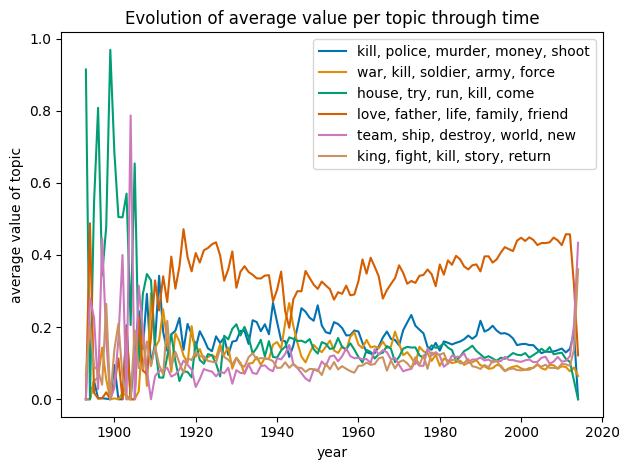

In [ ]:
colors = sns.color_palette('colorblind')
for topic in range(0,6):
    plt.plot(plots_year.index, plots_year["average_topic_{}".format(topic)], label=words_per_topic[topic], color=colors[topic])

plt.legend()
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of average value per topic through time")
plt.tight_layout()

We see that in the beginning (around 1900), the averages seem to be very unstable. This is likely due to the fact that in this time periods not too many data is available, as we saw in the beginning of the notebook. Therefore, let's limit ourselves to the time period from 1950 to 2009.

Text(0.5, 1.0, 'Amount of movies in each year')

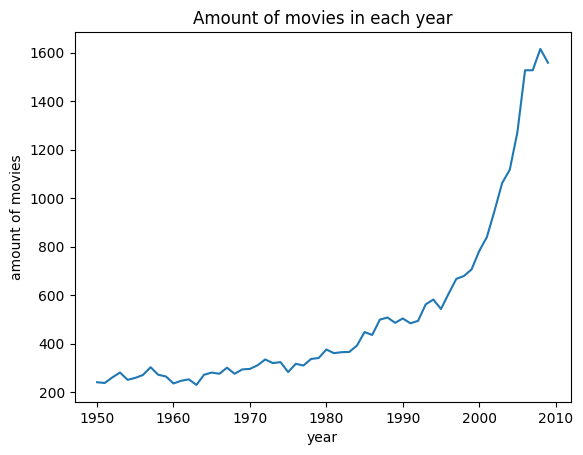

In [ ]:
plots_year_60_09 = plots_year[1950:2009]
plt.plot(plots_year_60_09.index, plots_year_60_09.movie_count)
plt.xlabel("year")
plt.ylabel("amount of movies")
plt.title("Amount of movies in each year")

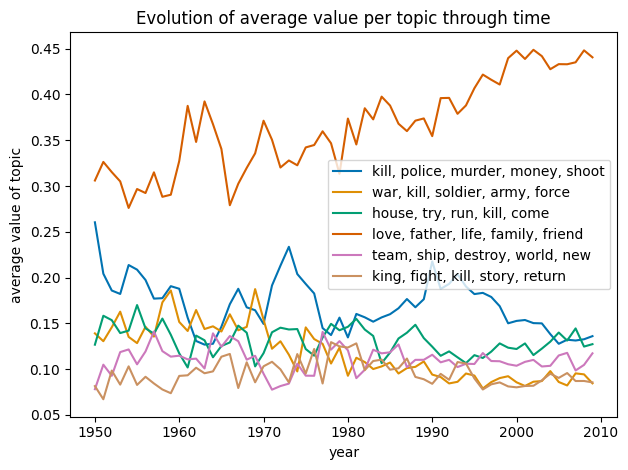

In [ ]:
for topic in range(0,6):
    plt.plot(plots_year_60_09.index, plots_year_60_09["average_topic_{}".format(topic)], label=words_per_topic[topic], color=colors[topic])

plt.legend()
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of average value per topic through time")
plt.tight_layout()

The average distribution still look quite unstable however. Therefore instead of averaging over one year, let's average over a period of five years.

In [ ]:
# Takes weighted average of the average probability distributions of each year, weighted by the amount of movies in each year
# This way we basically get the average probability distribution for the time period of the given group
def weighted_avg(group, amount_topics=6):
    result = dict()
    for topic in range(amount_topics):
        # weighted average by amount of movies in year, this way every movie in time period contributes the same amount
        weighted_sum = sum(group["average_topic_{}".format(topic)]*group.movie_count)
        total_movies = sum(group.movie_count)
        result["average_topic_{}".format(topic)] = weighted_sum/total_movies if total_movies else 0
    return pd.Series(result)

plots_year["period"] = (plots_year.index//5)*5
plots_5year = plots_year.groupby("period").apply(weighted_avg)
plots_5year_60_09 = plots_5year.loc[1960:2009]

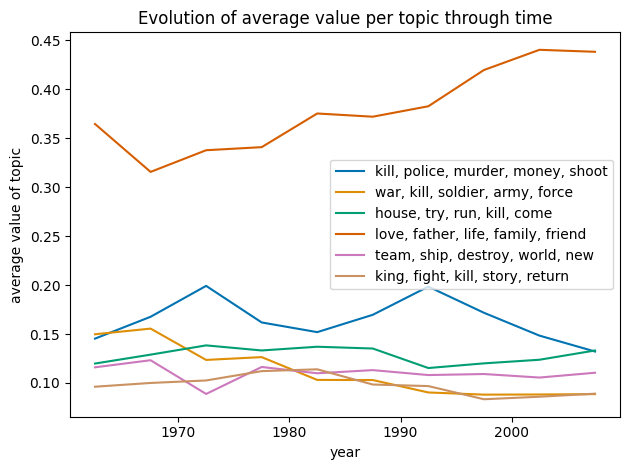

In [ ]:
for topic in range(0,6):
    # we add 2.5 to the index of each period, so that the value for e.g. the period 1960-65 is displayed at 1962.5
    plt.plot(plots_5year_60_09.index + 2.5, plots_5year_60_09["average_topic_{}".format(topic)], label=words_per_topic[topic], color=colors[topic])

plt.legend()
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of average value per topic through time")
plt.tight_layout()

Before we try to interpret this plot, we have to consider one more thing. At the moment we are not taking into account the popularity of a movie. In the previous plots, the plain average of the topic distributions is taken for each time period. However, to better capture which topics were popular in movies in which time periods, it might be a better idea to take also the popularity of each movie into account. One proxy for popularity is the box office revenue, which we will use here.

In [ ]:
# First filter out all movies without a box office revenue value (we assume they are missing completely at random)
plot_summaries_filt = plot_summaries[plot_summaries["box_office_revenue"].notna()]

# add period
plot_summaries_filt["period"] = (plot_summaries_filt["release_year"]//5)*5

/var/folders/t8/93t01cl96px6ff55chv5jznw0000gn/T/ipykernel_67404/3743660159.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_summaries_filt["period"] = (plot_summaries_filt["release_year"]//5)*5


In [ ]:
# This function computes the weighted average of the topic distribution of the given group. The topic distribution of each movie 
# is weighted by the movie's box office revenue.
def average_per_topic_weighted(group, amount_topics=6):
    
    averages = np.zeros(amount_topics)
    
    # iterate over all movies
    for index, movie in group.iterrows():
        # iterate over topic distribution
        for (topic, value) in movie['{}-topic model distibution'.format(amount_topics)]:
            averages[topic] += value * movie.box_office_revenue # weighted by box office
    total_box_office = sum(group.box_office_revenue)
    averages = averages / total_box_office if total_box_office else 0
    
    result = dict()
    for topic in range(amount_topics):
        result["average_topic_{}".format(topic)] = averages[topic]
    
    return pd.Series(result)

plots_5year_weighted = plot_summaries_filt.groupby("period").apply(average_per_topic_weighted)
plots_5year_weighted_50_09 = plots_5year_weighted.loc[1950:2009]

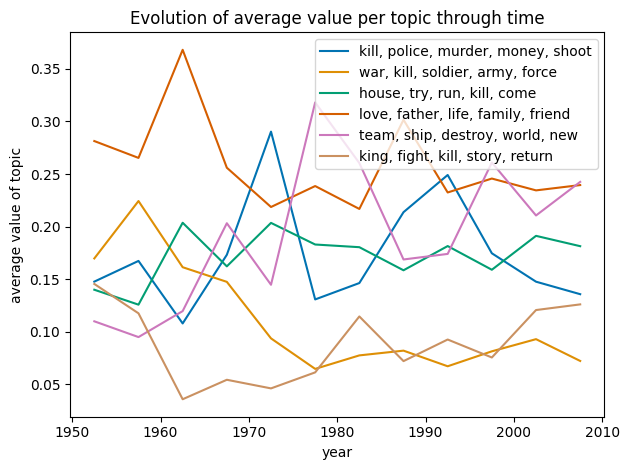

In [ ]:

for topic in range(0,6):
    plt.plot(plots_5year_weighted_50_09.index + 2.5, plots_5year_weighted_50_09["average_topic_{}".format(topic)], label=words_per_topic[topic], color=colors[topic])

plt.legend()
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of average value per topic through time")
plt.tight_layout()

We can start to try to interpret this plot! The "house, try, run, kill, come"-topic (previously interpreted as the horror/crime topic) and  the "king, fight, kill, story, return"-topic (previously interpreted as fantasy/adventure) seem to stay mostly constant. Therefore its hard to make any interesting analysises about these, except for concluding that these topics have remained popular throughout the years. For the other topics, let's look at the evolution of their values seperately. 

- **Evolution of topic: war, kill, soldier, army, force**
When we look at the evolution of the topic that contains mostly words that can be linked to war movies, we see that this topic is still quite relevant in the period 1950-1960. This should be not too surprising, as this is the period right after the world had seen two big wars. It is not surprising that war was still an intriguing concept at that time! We see that as the two big wars became more something of a distant past, the war topic became less prevelant in movies. 
- **Evolution of topic love, father, life, family, friend**
When we look at the evolution of the "love" topic, the first thing that jumps into the eye is the big peak around the year 1960. This is also not surprising if we know the cultural climate of the sixties! The cultural climate of the 1960s was marked by the hippie movement, which embraced values of love, peace, and camaraderie.

### Evolution of "war"-topic

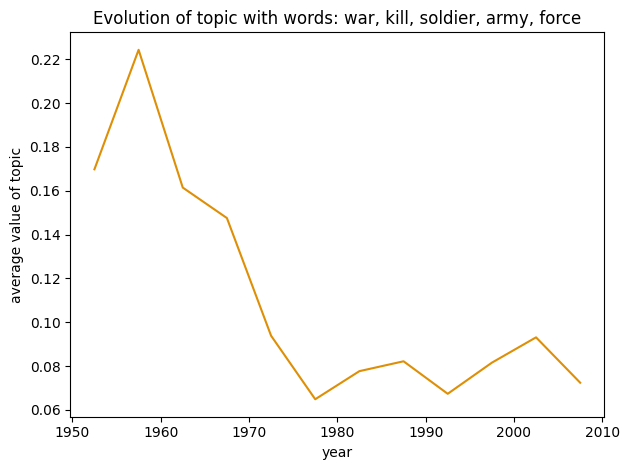

In [ ]:
plt.plot(plots_5year_weighted_50_09.index + 2.5, plots_5year_weighted_50_09["average_topic_{}".format(1)], color=colors[1])
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of topic with words: " + words_per_topic[1])
plt.tight_layout()

When we look at the evolution of the topic that contains mostly words that can be linked to war movies, we see that this topic is still quite relevant in the period 1950-1960. This should be not too surprising, as this is the period right after the world had seen two big wars. It is not surprising that war was still an intriguing concept at that time! We see that as the two big wars were longer and longer ago, the war topic also became less and less prevelant in movies. From 1980 the value remains mostly constant.

### Evolution of "love"-topic

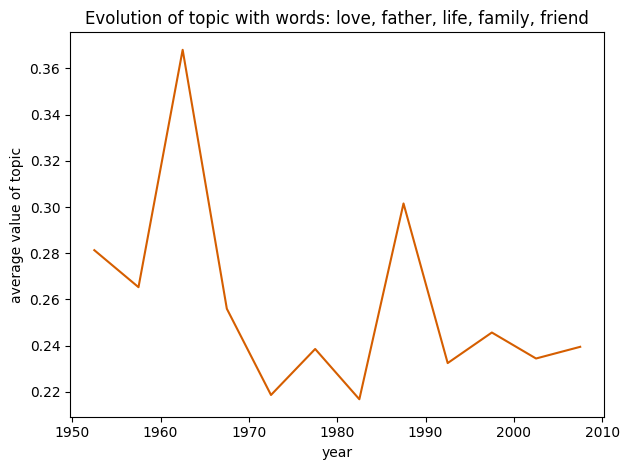

In [ ]:
plt.plot(plots_5year_weighted_50_09.index + 2.5, plots_5year_weighted_50_09["average_topic_{}".format(3)], color=colors[3])
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of topic with words: " + words_per_topic[3])
plt.tight_layout()

When we look at the evolution of the "love" topic, the first thing that jumps into the eye is the big peak around the year 1960. This is also not surprising if we know the cultural climate of the sixties! The cultural climate of the 1960s was marked by the hippie movement, which embraced values of love, peace, and camaraderie.

### Evolution of superhero/science-fiction topic

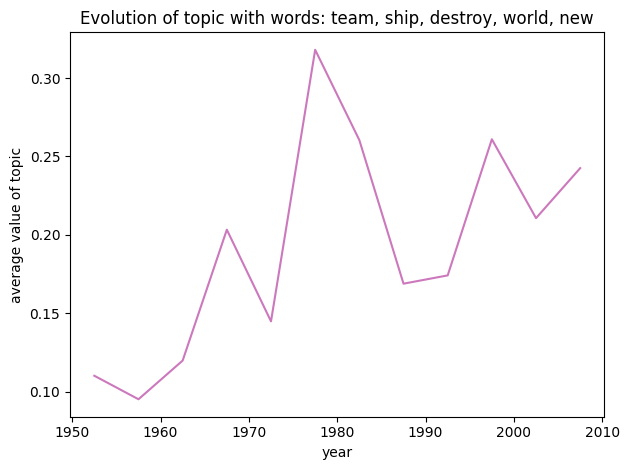

In [ ]:
plt.plot(plots_5year_weighted_50_09.index + 2.5, plots_5year_weighted_50_09["average_topic_{}".format(4)], color=colors[4])
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of topic with words: " + words_per_topic[4])
plt.tight_layout()

When we look at the evolution of the superhero topic, we see that there is an upwards trend. This can be attributed to the rising popularity of movies that are adaptations of superhero comic books.

### Topic evolution in the US

To be able to more clearly link the evolution of topics to cultural trends, lets now only look at movies released in the US.

First we do a quick check to see how the US is represented in the dataframe.

In [ ]:
list_all_countries = plot_summaries.countries.apply(lambda x: list(eval(x).values()) if not pd.isnull(x) else None)

In [ ]:
unique_countries = np.sort(list_all_countries.explode().dropna().unique())

In [ ]:
print(unique_countries)

['Afghanistan' 'Albania' 'Algeria' 'Argentina' 'Armenia' 'Aruba'
 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh'
 'Belgium' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Brazil' 'Bulgaria'
 'Burkina Faso' 'Burma' 'Cambodia' 'Cameroon' 'Canada' 'Chile' 'China'
 'Colombia' 'Congo' 'Costa Rica' 'Crime' 'Croatia' 'Cuba' 'Cyprus'
 'Czech Republic' 'Czechoslovakia' 'Democratic Republic of the Congo'
 'Denmark' 'Egypt' 'England' 'Estonia' 'Ethiopia'
 'Federal Republic of Yugoslavia' 'Finland' 'France' 'Georgia'
 'Georgian SSR' 'German Democratic Republic' 'German Language' 'Germany'
 'Greece' 'Guinea' 'Guinea-Bissau' 'Haiti' 'Hong Kong' 'Hungary' 'Iceland'
 'India' 'Indonesia' 'Iran' 'Iraq' 'Iraqi Kurdistan' 'Ireland'
 'Isle of Man' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kenya'
 'Kingdom of Great Britain' 'Kingdom of Italy' 'Korea' 'Kuwait' 'Lebanon'
 'Libya' 'Lithuania' 'Luxembourg' 'Macau' 'Malayalam Language' 'Malaysia'
 'Mali' 'Malta' 'Mandatory Palestine' 'Mexic

We can see that US is uniquely identified as 'United States of America'

In [ ]:
# keep only movies released in US and with box office revenue
movies_released_US = plot_summaries_filt.countries.apply(lambda x: 'United States of America' in eval(x).values() if not pd.isnull(x) else False)
plot_summaries_US = plot_summaries_filt[movies_released_US]


In [ ]:
plots_US_5year_weighted = plot_summaries_US.groupby("period").apply(average_per_topic_weighted)
plots_US_5year_weighted_50_09 = plots_US_5year_weighted[1950:2009]

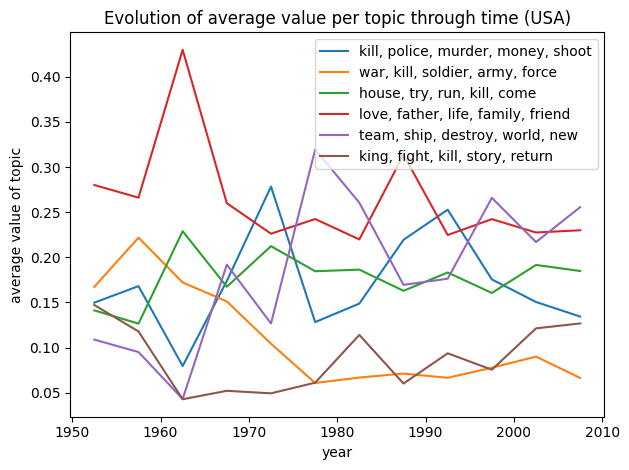

In [ ]:
for topic in range(0,6):
    plt.plot(plots_US_5year_weighted_50_09.index + 2.5, plots_US_5year_weighted_50_09["average_topic_{}".format(topic)], label=words_per_topic[topic])

plt.legend()
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of average value per topic through time (USA)")
plt.tight_layout()

Mostly, the same analyses as before hold. For the "love"-topic, we see an even bigger peak around 1960, which makes sense if we take into account the fact that the hippie-movement was very big in the US. Furthermore now it also makes sense to look at the evolution of the "gangster"-topic individually.

### Evolution of "gangster"-topic in the US

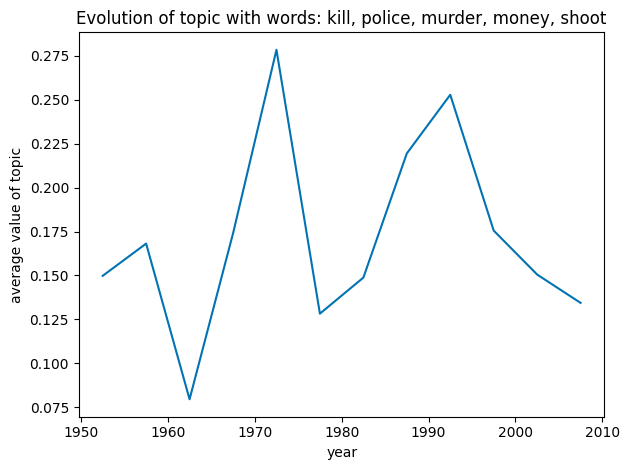

In [ ]:
topic=0
plt.plot(plots_US_5year_weighted_50_09.index + 2.5, plots_US_5year_weighted_50_09["average_topic_{}".format(topic)], color=colors[topic])

plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of topic with words: " + words_per_topic[topic])
plt.tight_layout()

When we look at this plot, we distinctly see two peaks. One around the year 1970 and one around the year 1990. Now look at the following figure displaying the homocide rate (a metric for crime) in the US from 1950 onwards.

![US crime rate](img/US-Homicide-Rate-1950-1999_W640.jpg)


It might be a little far fetched, but we see that the crime rate follows a similar pattern, with also peaks in the period 1970-1975 and 1990-95!

### Conclusion

Overall, when we look at the evolutions of the prevelance of topics in movies, it seems like we can link this to the cultural climate and the zeitgeist in these perdiods. This supports the hypothesis that the movie industry is a reflection of the current cultural climate.

# Plot originality


Firstly, we will try to apply a clustering algorithm to visualise the different topics and how they relate to each other. What we would like to observe here is some clear cluster cores that would represent movies with only one topic, and then some sparseness from the mix topic movies. The movies on the edges of a cluster would be those that are more original and more genre-mix.

In [ ]:

movie_topic_distr = plot_summaries.query("release_year < 2010 and release_year > 2000")["6-topic model distibution"]
data_points = []
for distr in movie_topic_distr:
    new_row = [0,0,0,0,0,0]
    for (topic, value) in distr:
        new_row[topic] = value
    data_points.append(new_row)

data_points = pd.DataFrame(data_points)


In [ ]:
data_reduced = PCA(n_components=2).fit_transform(data_points)

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(data_points)

/home/oriol/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


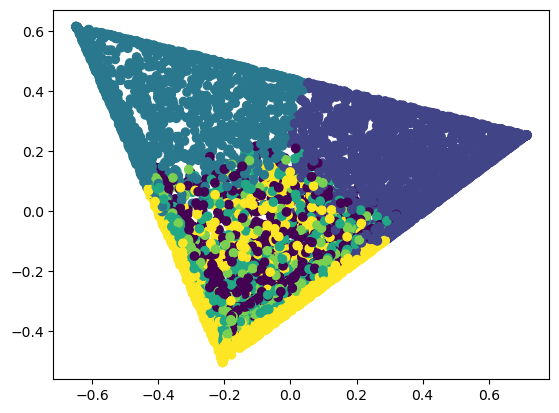

In [ ]:
labels = kmeans.predict(data_points)
plt.scatter(data_reduced[:,0], data_reduced[:,1],c=labels)


From the plot above few can be said actually. Two big clear clusters can be observed but the other four overlap very confusingly. Also, we do not get an idea of what space and distance mean here.

That is why we abandon this methodology and proceed with the computation of cosine similarity a much more interpretable measure.

In [ ]:
from similarity import cosine_similarity

[nltk_data] Downloading package wordnet to /home/oriol/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Compute mean pairwise cosine distnace
def average_weighted_cosine_distance(row, df):
    # new data set with movies from the same year
    same_year_movies = df[df['release_year'] == row['release_year']]
    # compute a list of the pairwise similarity with the other movies of that same year
    similarities = [cosine_similarity(dict(row['6-topic model distibution']), dict(other_row['6-topic model distibution'])) 
                    for idx, other_row in same_year_movies.iterrows() 
                    if other_row['wiki_movie_id'] != row['wiki_movie_id']]
    
    # return the mean
    return np.mean(similarities)


In the following cell the average cosine similarity is computed for every movie. The average cosine similarity consists on a pair-wise comparison with the movies released the same year. The cosine similarity is computed on the 6-topic model distribution. 

Therefore, one can expect that movies with more than one topic to be more similar to others since they will have more in common. We have defined those movies as original since they represent a mix of topics, creating a unique thematic. On the other hand, those movies with low cosine similarity will be pure stereotypical movies having an LDA vector of one single topic close to 100% probability. Since there is only 6 topics in our analysis we do not see as a problem if a topic is very unique on itself, oppositely as we have seen earlier in the report our topics are very much related to stereotypical genres. Furthermore, we know that the value obtained will be between 0 and 1 since the probabilites on LDA sum up to one. However, a value of 1 is impossible since it would mean a movie is identical to all the movies, and that values over 0.6, having the quantity of data we have, would be very rare.

In [ ]:
try:
    plot_summaries = pd.read_pickle("./avg_cosine_similarity.pkl")

except FileNotFoundError:
    plot_summaries['avg_cosine_similarity'] = plot_summaries.apply(lambda row: average_weighted_cosine_distance(row, plot_summaries), axis=1)
    plot_summaries.to_pickle("./avg_cosine_similarity.pkl")

In [ ]:
print(plot_summaries['avg_cosine_similarity'])

0        0.436781
1        0.382455
2        0.290958
3        0.515613
4        0.540312
           ...   
42298    0.374551
42299    0.536722
42300    0.407750
42301    0.398547
42302    0.390618
Name: avg_cosine_similarity, Length: 42303, dtype: float64


Now, let's check how movie originality has changed through the years! By taking the mean of each year we can grasp a sense of how original or how stereotypical were movies in that year. 

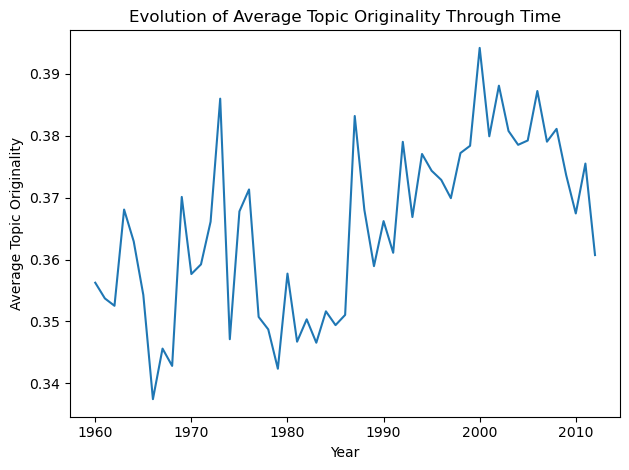

In [ ]:
avg_similarity_per_year = plot_summaries.groupby('release_year').mean('avg_cosine_similarity')['avg_cosine_similarity']

# too few movies for years previous than 1960 and after 2013
# 2013 as well since it only has 70 movies
avg_similarity_per_year_from60s = avg_similarity_per_year.loc[(avg_similarity_per_year.index >= 1960) & (avg_similarity_per_year.index < 2013)]

plt.plot(avg_similarity_per_year_from60s.index, avg_similarity_per_year_from60s)

plt.xlabel("Year")
plt.ylabel("Average Topic Originality")
plt.title("Evolution of Average Topic Originality Through Time")
plt.tight_layout()

On the plot above, we get an index between 0 and 1 of how original are the movies within one year. The values are comprended in a 0.05 section which it is not much but it can be understood as a 5% difference in originality. For instance, a tendency starting in the 1980s can be observed towards more stereotype-breaking movies up to the 2000s. From there some sort of regression is observed to the 2010s.

In [ ]:
plot_summaries_similarity= plot_summaries.query('release_year >= 1960  and release_year < 2013')
plot_summaries_similarity['avg_cosine_similarity'].describe()

count    31349.000000
mean         0.370761
std          0.093249
min          0.103685
25%          0.295850
50%          0.376324
75%          0.447650
max          0.595010
Name: avg_cosine_similarity, dtype: float64

Here we have the 5 top least original movies. Most of them are around the 1970s and have as topic 2 as the most probable topic. Furthermore, all of them have a science-fiction genre-like with some sort of apocalicthical mutant invasion theme. 

In [ ]:
print(display(plot_summaries_similarity.nsmallest(5,['avg_cosine_similarity'])))

,wiki_movie_id,plot,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres,BoW,6-topic model distibution,release_year,avg_cosine_similarity
18109,6071821,An earthquake releases a bunch of mutant cockr...,/m/0fnn52,Bug,1975-06-17,3602023.0,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06vxwl5"": ""Natural horror films"", ""/m/03n...","[(76, 1), (179, 1), (226, 1), (686, 1), (958, ...","[(2, 0.9745123)]",1975.0,0.103685
12096,4075105,A fictitious scientist called Dr. Nils Hellstr...,/m/0bgtvd,The Hellstrom Chronicle,1971-06-28,NaN,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/0219x_"": ""Indie"", ...","[(94, 2), (124, 3), (163, 1), (254, 1), (281, ...","[(2, 0.98317486)]",1971.0,0.107156
41923,8401836,"Set in a remote California community, the film...",/m/0gjcqx6,Stigma,1972,NaN,93.0,{},{},"{""/m/07s9rl0"": ""Drama""}","[(90, 1), (99, 1), (195, 1), (233, 1), (268, 1...","[(2, 0.9504643)]",1972.0,0.113148
19423,5527653,The Helios 7 space probe is sent on a mission ...,/m/0dq_ll,Space Amoeba,1970-08-01,NaN,83.0,"{""/m/03_9r"": ""Japanese Language"", ""/m/02h40lc""...","{""/m/03_3d"": ""Japan""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","[(10, 1), (42, 1), (44, 2), (47, 2), (56, 2), ...","[(2, 0.9737241), (5, 0.021530574)]",1970.0,0.116055
40652,26240693,In the year 2163 the starship Ikarie XB-1 is ...,/m/0b74hzj,Ikarie XB-1,1963,NaN,86.0,"{""/m/01wgr"": ""Czech Language"", ""/m/02h40lc"": ""...","{""/m/01mk6"": ""Czechoslovakia""}","{""/m/06n90"": ""Science Fiction""}","[(75, 1), (87, 1), (143, 1), (210, 1), (214, 2...","[(2, 0.98577493)]",1963.0,0.117642


None


These are the most genre-mix, or as we have definied originality, movies. It is not weird to see that the movie's topic are sparsely distributed. Here, the films have different background. For instance, the first movie, "The Sea", is a Catalan film in which two young men and a woman who shared the same traumatic childhood experience during the Spanish Civil War are reunited years later at a hospital for tuberculosis treatment. You can tell is not your average blockbuster movie.

However, the second one, "They Still Call Me Bruce", is about a Korean man comes to America to thank the American GI who saved his life, but instead winds up running a struggling karate studio. It surely does not sound as profund as the first one, but here we are testing originality, and who would come with such idea?!

In [ ]:
print(display(plot_summaries_similarity.nlargest(5,['avg_cosine_similarity'])))

,wiki_movie_id,plot,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres,BoW,6-topic model distibution,release_year,avg_cosine_similarity
12044,31186529,"In the summer of 1936, the violence of the Spa...",/m/0gh5_k_,The Sea,2000-04-14,NaN,113.0,"{""/m/01m69"": ""Catalan language""}","{""/m/06mkj"": ""Spain""}","{""/m/07s9rl0"": ""Drama""}","[(8, 2), (24, 1), (40, 1), (44, 1), (45, 1), (...","[(0, 0.12492112), (1, 0.38466993), (3, 0.22187...",2000.0,0.595010
15607,4037368,The movie begins with Bruce in Houston on a se...,/m/0bdttd,They Still Call Me Bruce,1987,NaN,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0gf28"": ""Parody"", ""/m/02kdv5l"": ""Action"",...","[(2, 2), (28, 1), (44, 3), (54, 1), (56, 1), (...","[(0, 0.19190046), (1, 0.28360564), (3, 0.10159...",1987.0,0.591950
15196,15117612,A young autistic woman named Zen has developed...,/m/03hj13r,Chocolate,2008,NaN,92.0,"{""/m/03_9r"": ""Japanese Language"", ""/m/0c_v2"": ...","{""/m/07f1x"": ""Thailand""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/02kdv5l...","[(2, 1), (10, 1), (11, 1), (15, 1), (19, 3), (...","[(0, 0.1550731), (1, 0.3265943), (2, 0.1328983...",2008.0,0.591419
35115,698969,Teenager Grace MacLean and her best friend Ju...,/m/033s0w,The Horse Whisperer,1998-05-15,186883563.0,168.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/068d7h"": ""Romantic drama"", ""/m/02l7c8"": ""...","[(8, 2), (26, 1), (40, 1), (44, 1), (90, 1), (...","[(0, 0.20248887), (1, 0.34291658), (3, 0.20365...",1998.0,0.590502
20318,19399172,The story follows the transient lives of four ...,/m/03gq3j_,Suzhou River,2000,NaN,83.0,"{""/m/0653m"": ""Standard Mandarin""}","{""/m/0d05w3"": ""China"", ""/m/0345h"": ""Germany""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/03q4nz"": ""Wo...","[(8, 6), (15, 2), (31, 1), (38, 1), (40, 1), (...","[(0, 0.14471196), (1, 0.38576236), (3, 0.30359...",2000.0,0.585909


None


# Unraveling Complexity: The Evolution of Movie Plots

## Load plot data

Create a duplicate of the movie_metadata dataset for analysis purposes, linking each plot to its respective movie. This step is essential for calculating various complexity indices for each film:
1. Wikipedia movie ID
2. Movie name
3. Lowercase title
4. Movie release year
5. Movie box office revenue
6. Movie runtime
7. Movie plot
8. Number of words in the plot summary

In [51]:
plot_complexity = movie_metadata[['wiki_movie_id','movie_name','lowercase_title','release_year','box_office_revenue','runtime']].copy()
plot_complexity = pd.merge(plot_complexity, plot_summaries, on='wiki_movie_id').copy()
plot_complexity['plot_word_count'] = plot_complexity['plot'].apply(cx.count_words)
print('number of nan values in plot_complexity:')
print(plot_complexity.isna().sum())
print('number of rows in plot_complexity:', plot_complexity.shape[0])
plot_complexity.head(1)

number of nan values in plot_complexity:
wiki_movie_id             0
movie_name                0
lowercase_title           0
release_year           2618
box_office_revenue    34617
runtime                6624
plot                      0
plot_word_count           0
dtype: int64
number of rows in plot_complexity: 42204


,wiki_movie_id,movie_name,lowercase_title,release_year,box_office_revenue,runtime,plot,plot_word_count
0,975900,Ghosts of Mars,ghosts of mars,2001.0,14010832.0,98.0,"Set in the second half of the 22nd century, th...",357


### Data cleaning

#### Release year

To facilitate the analysis of complexity evolution over the years, it is advisable to exclude movies with NaN values in the release_year field. Furthermore, based on the preliminary analysis of basic features, it is evident that the majority of movies in our dataset were released after 1920. Therefore, we can streamline our focus by concentrating on this subset. Additionally, to ensure data completeness, we exclude movies from the year 2013 from our analysis due to incomplete data for that particular year.Additionally, to ensure data completeness, we exclude movies from the year 2013 from our analysis due to incomplete data for that particular year.

number of nan values in plot_complexity:
wiki_movie_id             0
movie_name                0
lowercase_title           0
release_year              0
box_office_revenue    31437
runtime                4942
plot                      0
plot_word_count           0
dtype: int64
number of rows in plot_complexity: 38961


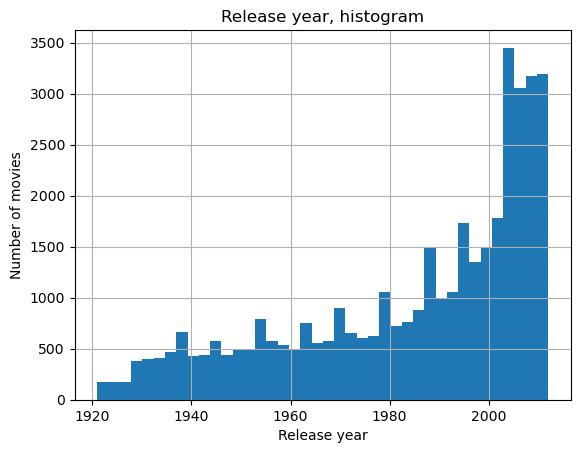

In [52]:
# remove nan release_year and consider movies between 1920-2012
plot_complexity = plot_complexity[(plot_complexity['release_year'] > 1920) & (plot_complexity['release_year'] < 2013)]

print('number of nan values in plot_complexity:')
print(plot_complexity.isna().sum())
print('number of rows in plot_complexity:', plot_complexity.shape[0])
plot_complexity['release_year'].dropna().hist(bins = 40, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of movies')
plt.title('Release year, histogram');

#### Runtime (observations)

From the preliminary analysis of basic features, it's evident that the majority of movies in the dataset have a runtime of less than 250 minutes. Furthermore, to ensure the robustness of our analysis, we may want to exclude movies with a duration of less than 5 minutes. Although this represents a small subset of all movies, it is a necessary step as exceptionally short durations may impact our complexity index in certain cases.

if we restrict to the movies that have a runtime between 5 and 250
number of rows in plot_complexity: 33824


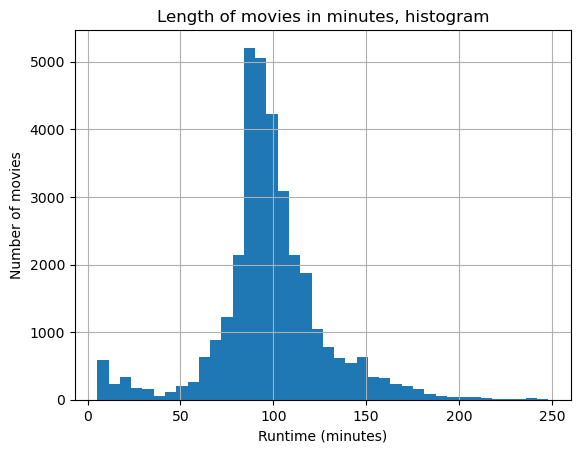

In [53]:
lower_runtime = 5
upper_runtime = 250

print('if we restrict to the movies that have a runtime between {} and {}'.format(lower_runtime, upper_runtime))
print('number of rows in plot_complexity:', plot_complexity[(plot_complexity['runtime'] > lower_runtime) & (plot_complexity['runtime'] < upper_runtime)].shape[0])

plot_complexity[(plot_complexity['runtime'] > lower_runtime) & (plot_complexity['runtime'] < upper_runtime)]['runtime'].dropna().hist(bins = 40, log=False)
plt.xlabel('Runtime (minutes)')
plt.ylabel('Number of movies')
plt.title('Length of movies in minutes, histogram');

#### Plot summary (observations)

if we restrict to the movies that have a number of words in the plot summary between 100 and 2000
number of rows in plot_complexity: 27725


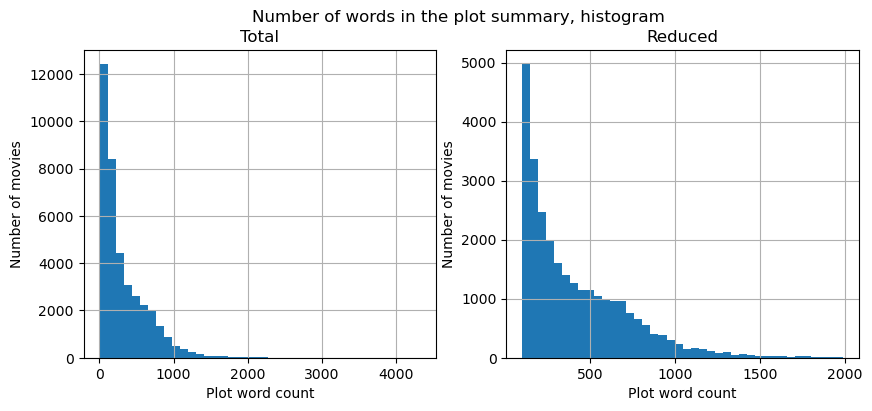

In [54]:
lower_plot = 100
upper_plot = 2000
print('if we restrict to the movies that have a number of words in the plot summary between {} and {}'.format(lower_plot, upper_plot))
print('number of rows in plot_complexity:', plot_complexity[(plot_complexity['plot_word_count'] > lower_plot) & (plot_complexity['plot_word_count'] < upper_plot)].shape[0])

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plot_complexity['plot_word_count'].dropna().hist(bins = 40, log=False)
plt.xlabel('Plot word count')
plt.ylabel('Number of movies')
plt.title('Total');
plt.subplot(1, 2, 2)
plot_complexity[(plot_complexity['plot_word_count'] > lower_plot) & (plot_complexity['plot_word_count'] < upper_plot)]['plot_word_count'].dropna().hist(bins = 40, log=False)
plt.xlabel('Plot word count')
plt.ylabel('Number of movies')
plt.title('Reduced')
plt.suptitle('Number of words in the plot summary, histogram')
plt.show()

## Complexity indices

### Plot summary length over runtime

One approach to assessing the complexity of a film involves establishing a complexity score derived from the plot summary's length, normalized in relation to the runtime. This is grounded in the assumption that extended plot summaries generally correlate with lengthier runtimes.

Generate a copy of the "plot_complexity" dataset, to be filtered. We will exclude movies with runtimes less than 2 minutes or exceeding 300 minutes, as well as films with plot summary word counts with more than 100 words, in order to limitate the influence of outliers.

In [55]:
plot_complexity_len_runtime = plot_complexity[['wiki_movie_id','movie_name','release_year','runtime','plot_word_count']].copy()

# compute complexity 
plot_complexity_len_runtime['len/runtime'] = plot_complexity_len_runtime['plot_word_count']/plot_complexity_len_runtime['runtime']

# merge and add the computed complexity to the dataframe plot_complexity
plot_complexity = pd.merge(plot_complexity, plot_complexity_len_runtime[['wiki_movie_id','len/runtime']],  on='wiki_movie_id', how='left')
plot_complexity.head(1)

,wiki_movie_id,movie_name,lowercase_title,release_year,box_office_revenue,runtime,plot,plot_word_count,len/runtime
0,975900,Ghosts of Mars,ghosts of mars,2001.0,14010832.0,98.0,"Set in the second half of the 22nd century, th...",357,3.642857


In [56]:
# filtering data
plot_complexity_len_runtime = plot_complexity[(plot_complexity['runtime'] > 2)
                                              & (plot_complexity['runtime'] < 300)
                                              & (plot_complexity['plot_word_count'] > 100)][['wiki_movie_id','release_year','runtime','plot_word_count','len/runtime']]


print('initial number of movies:', plot_complexity.shape[0])
print('reduced number of movies (runtime, plot summary):\n', plot_complexity_len_runtime.shape[0])

initial number of movies: 38961
reduced number of movies (runtime, plot summary):
 24554


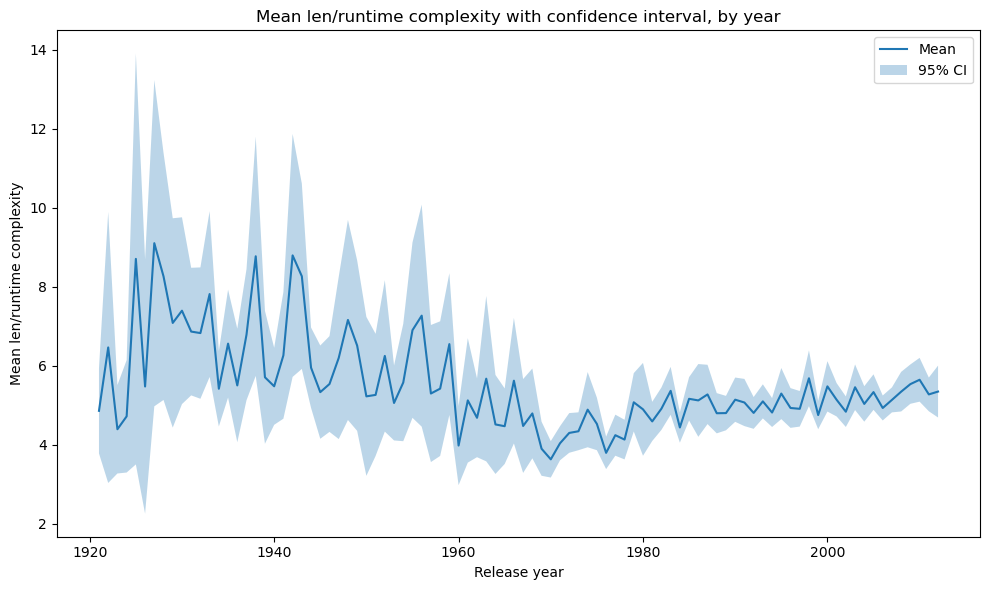

In [57]:
len_runtime_complexity_by_year = plot_complexity_len_runtime.groupby('release_year')['len/runtime'].agg(['count','mean','std']).reset_index()
len_runtime_complexity_by_year['ci_low'] = len_runtime_complexity_by_year['mean'] - 1.96 * (len_runtime_complexity_by_year['std'] / len_runtime_complexity_by_year['count']**0.5)
len_runtime_complexity_by_year['ci_high'] = len_runtime_complexity_by_year['mean'] + 1.96 * (len_runtime_complexity_by_year['std'] / len_runtime_complexity_by_year['count']**0.5)

plt.figure(figsize=(10, 6))
sns.lineplot(x='release_year', y='mean', data=len_runtime_complexity_by_year, label='Mean')
plt.fill_between(len_runtime_complexity_by_year['release_year'], len_runtime_complexity_by_year['ci_low'], len_runtime_complexity_by_year['ci_high'], alpha=0.3, label='95% CI')
plt.xlabel('Release year')
plt.ylabel('Mean len/runtime complexity')
plt.title('Mean len/runtime complexity with confidence interval, by year')
plt.legend()
plt.tight_layout()
plt.show()

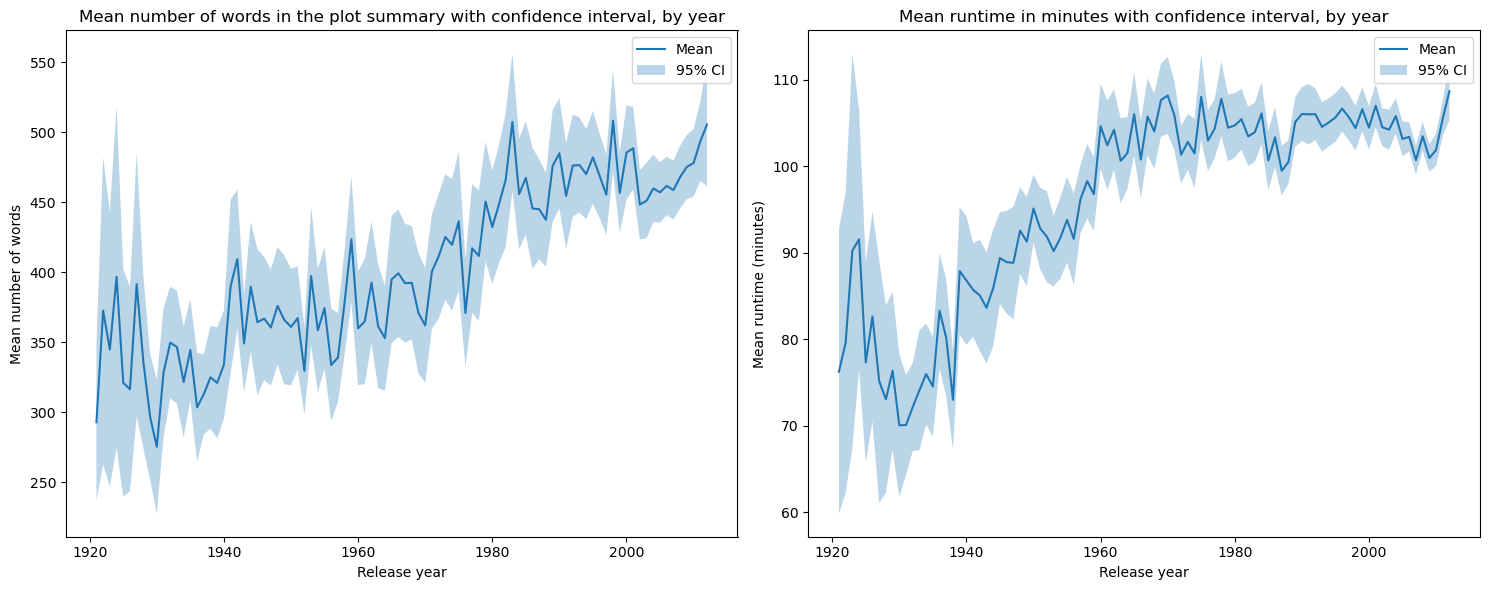

In [58]:
plot_word_count_by_year = plot_complexity_len_runtime.groupby('release_year')['plot_word_count'].agg(['count','mean','std']).reset_index()
plot_word_count_by_year['ci_low'] = plot_word_count_by_year['mean'] - 1.96 * (plot_word_count_by_year['std'] / plot_word_count_by_year['count']**0.5)
plot_word_count_by_year['ci_high'] = plot_word_count_by_year['mean'] + 1.96 * (plot_word_count_by_year['std'] / plot_word_count_by_year['count']**0.5)

runtime_by_year = plot_complexity_len_runtime.groupby('release_year')['runtime'].agg(['count','mean','std']).reset_index()
runtime_by_year['ci_low'] = runtime_by_year['mean'] - 1.96 * (runtime_by_year['std'] / runtime_by_year['count']**0.5)
runtime_by_year['ci_high'] = runtime_by_year['mean'] + 1.96 * (runtime_by_year['std'] / runtime_by_year['count']**0.5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.lineplot(x='release_year', y='mean', data=plot_word_count_by_year, ax=axes[0], label='Mean')
axes[0].fill_between(plot_word_count_by_year['release_year'], plot_word_count_by_year['ci_low'], plot_word_count_by_year['ci_high'], alpha=0.3, label='95% CI')
axes[0].set_xlabel('Release year')
axes[0].set_ylabel('Mean number of words')
axes[0].set_title('Mean number of words in the plot summary with confidence interval, by year')
axes[0].legend()

sns.lineplot(x='release_year', y='mean', data=runtime_by_year, ax=axes[1], label='Mean')
axes[1].fill_between(runtime_by_year['release_year'], runtime_by_year['ci_low'], runtime_by_year['ci_high'], alpha=0.3, label='95% CI')
axes[1].set_xlabel('Release year')
axes[1].set_ylabel('Mean runtime (minutes)')
axes[1].set_title('Mean runtime in minutes with confidence interval, by year')
axes[1].legend()

plt.tight_layout()
plt.show()

### Lexical richness

Generate a copy of the "plot_complexity" dataset. We will exclude movies with plot summary word counts outside the range of 100 to 2000 words.

In [59]:
# data saved in: plot_complexity_lexic.csv
'''
plot_complexity_lexic = plot_complexity[['wiki_movie_id','movie_name','release_year','plot','plot_word_count']].copy()

# compute complexity
plot_complexity_lexic['TTR_lexical_complexity'] = plot_complexity_lexic['plot'].apply(lambda text: cx.lexical_complexity(text, 'TTR'))
plot_complexity_lexic['mass_lexical_complexity'] = plot_complexity_lexic['plot'].apply(lambda text: cx.lexical_complexity(text, 'mass'))
plot_complexity_lexic.to_csv('plot_complexity_lexic.csv')
'''

# load data
plot_complexity_lexic = pd.read_csv('plot_complexity_lexic.csv', index_col=0)
plot_complexity = pd.merge(plot_complexity,plot_complexity_lexic[['wiki_movie_id','TTR_lexical_complexity','mass_lexical_complexity']], on='wiki_movie_id', how='left')
plot_complexity.head(1)

,wiki_movie_id,movie_name,lowercase_title,release_year,box_office_revenue,runtime,plot,plot_word_count,len/runtime,TTR_lexical_complexity,mass_lexical_complexity
0,975900,Ghosts of Mars,ghosts of mars,2001.0,14010832.0,98.0,"Set in the second half of the 22nd century, th...",357,3.642857,0.23,0.325125


In [61]:
# filtering data
plot_complexity_lexic = plot_complexity[['wiki_movie_id','release_year','TTR_lexical_complexity','mass_lexical_complexity']]
plot_complexity_lexic = plot_complexity[(plot_complexity['plot_word_count'] > 100) & (plot_complexity['plot_word_count'] < 2000)][['wiki_movie_id','release_year','TTR_lexical_complexity','mass_lexical_complexity']]
print('initial number of movies:', plot_complexity.shape[0])
print('reduced number of movies (plot summary):\n', plot_complexity_lexic.shape[0])

initial number of movies: 38961
reduced number of movies (plot summary):
 27725


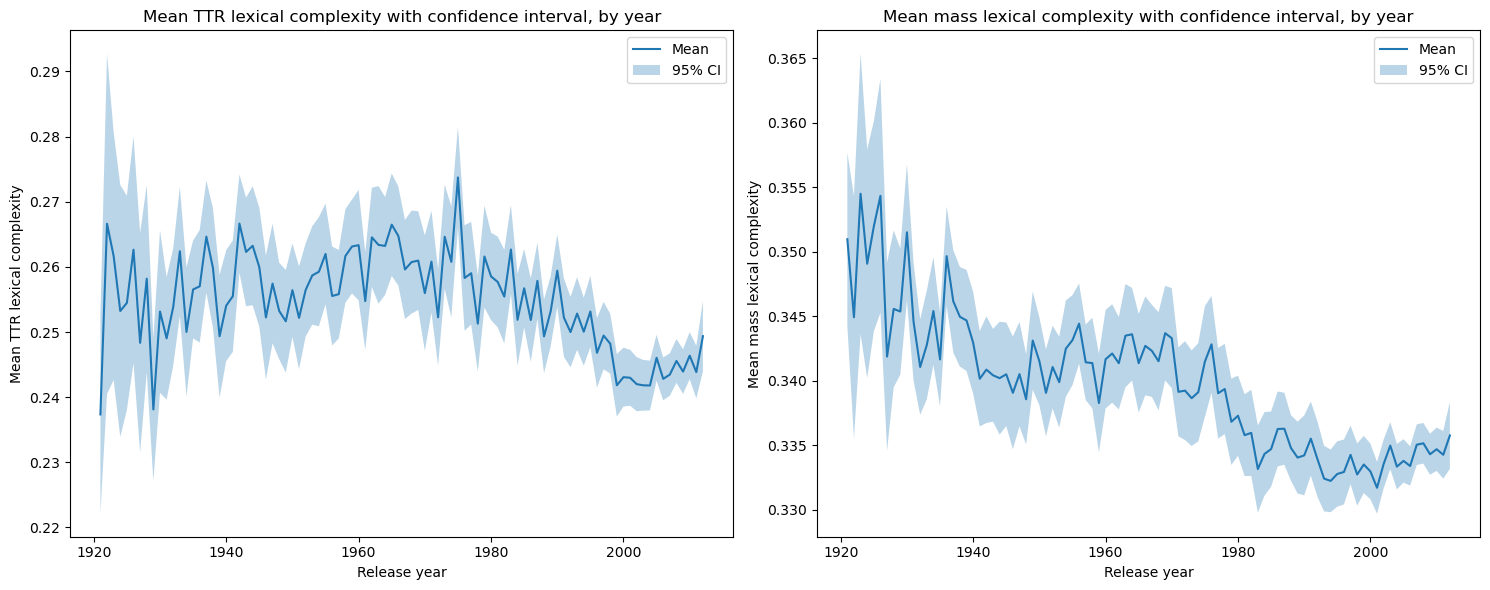

In [67]:
TTR_complexity_by_year = plot_complexity_lexic.groupby('release_year')['TTR_lexical_complexity'].agg(['count','mean','std']).reset_index()
TTR_complexity_by_year['ci_low'] = TTR_complexity_by_year['mean'] - 1.96 * (TTR_complexity_by_year['std'] / TTR_complexity_by_year['count']**0.5)
TTR_complexity_by_year['ci_high'] = TTR_complexity_by_year['mean'] + 1.96 * (TTR_complexity_by_year['std'] / TTR_complexity_by_year['count']**0.5)

mass_complexity_by_year = plot_complexity_lexic.groupby('release_year')['mass_lexical_complexity'].agg(['count','mean','std']).reset_index()
mass_complexity_by_year['ci_low'] = mass_complexity_by_year['mean'] - 1.96 * (mass_complexity_by_year['std'] / mass_complexity_by_year['count']**0.5)
mass_complexity_by_year['ci_high'] = mass_complexity_by_year['mean'] + 1.96 * (mass_complexity_by_year['std'] / mass_complexity_by_year['count']**0.5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.lineplot(x='release_year', y='mean', data=TTR_complexity_by_year, ax=axes[0], label='Mean')
axes[0].fill_between(TTR_complexity_by_year['release_year'], TTR_complexity_by_year['ci_low'], TTR_complexity_by_year['ci_high'], alpha=0.3, label='95% CI')
axes[0].set_xlabel('Release year')
axes[0].set_ylabel('Mean TTR lexical complexity')
axes[0].set_title('Mean TTR lexical complexity with confidence interval, by year')
axes[0].legend()

sns.lineplot(x='release_year', y='mean', data=mass_complexity_by_year, ax=axes[1], label='Mean')
axes[1].fill_between(mass_complexity_by_year['release_year'], mass_complexity_by_year['ci_low'], mass_complexity_by_year['ci_high'], alpha=0.3, label='95% CI')
axes[1].set_xlabel('Release year')
axes[1].set_ylabel('Mean mass lexical complexity')
axes[1].set_title('Mean mass lexical complexity with confidence interval, by year')
axes[1].legend()

plt.tight_layout()
plt.show()

## Plot analysis validation using scripts

One could argue that the preceding analysis ought to be carried out on the movie scripts rather than the plot summaries. To support our analysis, we present a dataset consisting of n scripts and conduct the same analysis to corroborate the validity of our findings.

### Load movie script data and preprocess

In [68]:
script_folder = './data/movie_scripts'
if not os.path.exists(script_folder):
        print(f"The folder '{script_folder}' does not exist.")
script_titles = pd.read_csv('./data/imsdb_script_sample.txt', sep='\t', header=None, names=['script_title'])
script_titles['lowercase_title'] = script_titles['script_title'].str.lower()
script_complexity = movie_metadata[['wiki_movie_id','movie_name','lowercase_title','release_year','box_office_revenue','runtime']].copy()
script_complexity = pd.merge(script_complexity, script_titles, on='lowercase_title')

print('number of rows in movie_metadata:\t', movie_metadata.shape[0])
print('number of available scripts:\t\t', script_titles.shape[0])
print('number of correspondig scripts:\t\t', script_complexity.shape[0])
print('number of nan values in script_complexity:')
print(script_complexity.isna().sum())
script_complexity.head(1)

number of rows in movie_metadata:	 81741
number of available scripts:		 1093
number of correspondig scripts:		 978
number of nan values in script_complexity:
wiki_movie_id           0
movie_name              0
lowercase_title         0
release_year           16
box_office_revenue    300
runtime                56
script_title            0
dtype: int64


,wiki_movie_id,movie_name,lowercase_title,release_year,box_office_revenue,runtime,script_title
0,77856,Mary Poppins,mary poppins,1964.0,102272727.0,139.0,Mary Poppins


In [69]:
scripts = lf.load_scripts(script_folder, script_complexity['script_title'].values)
scripts_df = pd.DataFrame([(k, v) for k, v in scripts.items()], columns=['script_title', 'script'])
script_complexity = pd.merge(script_complexity, scripts_df, on='script_title').copy()
script_complexity['script_word_count'] = script_complexity['script'].apply(cx.count_words)

print('number of nan values in script_complexity:')
print(script_complexity.isna().sum())
print('number of rows in script_complexity:\t', script_complexity.shape[0])
script_complexity.head(1)

number of nan values in script_complexity:
wiki_movie_id           0
movie_name              0
lowercase_title         0
release_year           16
box_office_revenue    292
runtime                55
script_title            0
script                  0
script_word_count       0
dtype: int64
number of rows in script_complexity:	 949


,wiki_movie_id,movie_name,lowercase_title,release_year,box_office_revenue,runtime,script_title,script,script_word_count
0,77856,Mary Poppins,mary poppins,1964.0,102272727.0,139.0,Mary Poppins,\n***** MARY POPPINS *****\n\n\n\nBert:\nAll r...,14096


#### Data cleaning

Utilizing an external dataset to extract scripts posed challenges due to merging issues. The sole metadata available for linking scripts to their respective movies was the movie name. However, since certain movies share the same name, a substantial portion of our dataset had to be excluded to ensure coherence. Specifically, movies with identical names had to be dropped from consideration.

In [70]:
print('number of rows in script_complexity:\t', script_complexity.shape[0])
print('number of unique scripts:\t', script_complexity['script_title'].unique().shape[0])

script_complexity = script_complexity.drop_duplicates(subset=['script_title'], keep=False)
print('number of rows, after drop:\t', script_complexity.shape[0])
print('number of nan values in script_complexity, after drop:')
print(script_complexity.isna().sum())


number of rows in script_complexity:	 949
number of unique scripts:	 740
number of rows, after drop:	 600
number of nan values in script_complexity, after drop:
wiki_movie_id           0
movie_name              0
lowercase_title         0
release_year            3
box_office_revenue    101
runtime                14
script_title            0
script                  0
script_word_count       0
dtype: int64


As we plan to analyze the evolution of complexity over the years, we can exclude movies with unknown release years from our dataset.

number of rows in script_complexity: 597


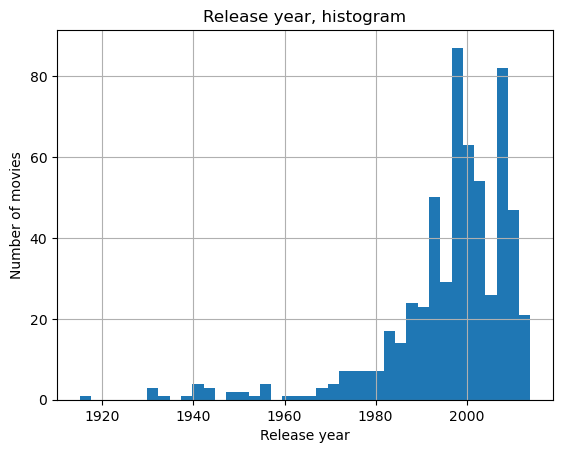

In [71]:
script_complexity = script_complexity[~script_complexity['release_year'].isna()]
#script_complexity = script_complexity[script_complexity['release_year'] > 1960]
print('number of rows in script_complexity:', script_complexity.shape[0])

script_complexity.release_year.dropna().hist(bins = 40, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of movies')
plt.title('Release year, histogram');

if we restrict to the movies that have a runtime between 60 and 200
number of rows in script_complexity: 582


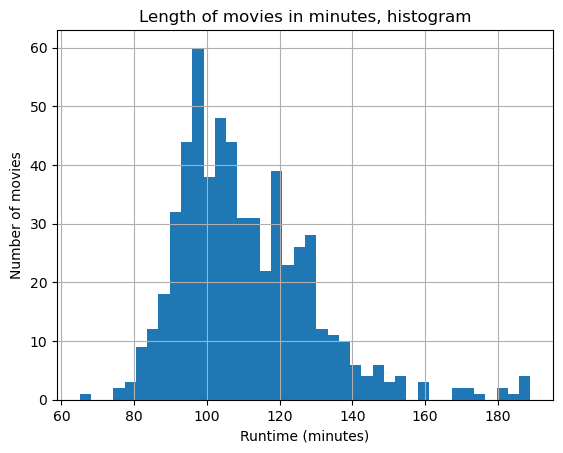

In [72]:
lower_runtime = 60
upper_runtime = 200

print('if we restrict to the movies that have a runtime between {} and {}'.format(lower_runtime, upper_runtime))
print('number of rows in script_complexity:', script_complexity[(script_complexity['runtime'] > lower_runtime) & (script_complexity['runtime'] < upper_runtime)].shape[0])

script_complexity[(script_complexity['runtime'] > lower_runtime) & (script_complexity['runtime'] < upper_runtime)]['runtime'].dropna().hist(bins = 40, log=False)
plt.xlabel('Runtime (minutes)')
plt.ylabel('Number of movies')
plt.title('Length of movies in minutes, histogram');

if we restrict to the movies that have a number of words in the script between 6000 and 45000
number of rows in plot_complexity: 593


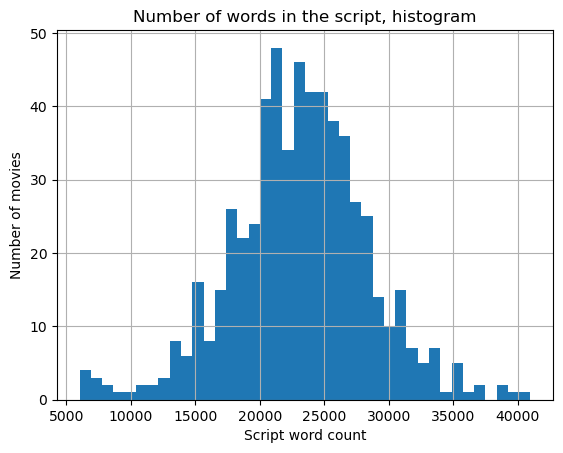

In [73]:
lower_script = 6000
upper_script = 45000
print('if we restrict to the movies that have a number of words in the script between {} and {}'.format(lower_script, upper_script))
print('number of rows in plot_complexity:', script_complexity[(script_complexity['script_word_count'] > lower_script) & (script_complexity['script_word_count'] < upper_script)].shape[0])

script_complexity[(script_complexity['script_word_count'] > lower_script) & (script_complexity['script_word_count'] < upper_script)]['script_word_count'].dropna().hist(bins = 40, log=False)
plt.xlabel('Script word count')
plt.ylabel('Number of movies')
plt.title('Number of words in the script, histogram');

### Complexity indices for scripts

#### Script length over runtime

In [74]:
script_complexity_len_runtime = script_complexity[['wiki_movie_id','movie_name','release_year','runtime','script_word_count']].copy()

# compute complexity 
script_complexity_len_runtime['len/runtime'] = script_complexity_len_runtime['script_word_count']/script_complexity_len_runtime['runtime']

# merge and add the computed complexity to the dataframe script_complexity
script_complexity = pd.merge(script_complexity, script_complexity_len_runtime[['wiki_movie_id','len/runtime']],  on='wiki_movie_id', how='left')
print('number of rows in script_complexity:', script_complexity.shape[0])
plot_complexity.head(1)

number of rows in script_complexity: 597


,wiki_movie_id,movie_name,lowercase_title,release_year,box_office_revenue,runtime,plot,plot_word_count,len/runtime,TTR_lexical_complexity,mass_lexical_complexity
0,975900,Ghosts of Mars,ghosts of mars,2001.0,14010832.0,98.0,"Set in the second half of the 22nd century, th...",357,3.642857,0.23,0.325125


In [75]:
# filtering data
script_complexity_len_runtime = script_complexity[['wiki_movie_id','release_year','runtime','script_word_count','len/runtime']]
script_complexity_len_runtime = script_complexity[(script_complexity['runtime'] > 60)
                                                  & (script_complexity['runtime'] < 200)
                                                  & (script_complexity['script_word_count'] > 6000)
                                                  & (script_complexity['script_word_count'] < 45000)][['wiki_movie_id','release_year','runtime','script_word_count','len/runtime']]

print('initial number of movies:', script_complexity.shape[0])
print('reduced number of movies:', script_complexity_len_runtime.shape[0])

initial number of movies: 597
reduced number of movies: 579


#### Lexical richness for scripts

In [77]:
# data saved in: plot_complexity_lexic.csv
'''
script_complexity_lexic = script_complexity[['wiki_movie_id','movie_name','release_year','script','script_word_count']].copy()

# compute complexity
script_complexity_lexic['TTR_lexical_complexity'] = script_complexity_lexic['script'].apply(lambda text: cx.lexical_complexity(text, 'TTR'))
script_complexity_lexic['mass_lexical_complexity'] = script_complexity_lexic['script'].apply(lambda text: cx.lexical_complexity(text, 'mass'))
script_complexity_lexic['RTTR_lexical_complexity'] = script_complexity_lexic['script'].apply(lambda text: cx.lexical_complexity(text,'RTTR'))
script_complexity_lexic['herdan_lexical_complexity'] = script_complexity_lexic['script'].apply(lambda text: cx.lexical_complexity(text,'herdan'))
script_complexity_lexic['summer_lexical_complexity'] = script_complexity_lexic['script'].apply(lambda text: cx.lexical_complexity(text,'summer'))
script_complexity_lexic['dugast_lexical_complexity'] = script_complexity_lexic['script'].apply(lambda text: cx.lexical_complexity(text,'dugast'))
script_complexity_lexic.to_csv('script_complexity_lexic.csv')
'''

# load data
script_complexity_lexic = pd.read_csv('script_complexity_lexic.csv', index_col=0)
script_complexity = pd.merge(script_complexity, script_complexity_lexic[['wiki_movie_id','TTR_lexical_complexity','mass_lexical_complexity']], on='wiki_movie_id', how='left')
print('number of nan values in plot_complexity:')
print(script_complexity.isna().sum())
print('number of rows in script_complexity:', script_complexity.shape[0])
script_complexity.head(1)

number of nan values in plot_complexity:
wiki_movie_id               0
movie_name                  0
lowercase_title             0
release_year                0
box_office_revenue         98
runtime                    12
script_title                0
script                      0
script_word_count           0
len/runtime                12
TTR_lexical_complexity      0
mass_lexical_complexity     0
dtype: int64
number of rows in script_complexity: 597


,wiki_movie_id,movie_name,lowercase_title,release_year,box_office_revenue,runtime,script_title,script,script_word_count,len/runtime,TTR_lexical_complexity,mass_lexical_complexity
0,77856,Mary Poppins,mary poppins,1964.0,102272727.0,139.0,Mary Poppins,\n***** MARY POPPINS *****\n\n\n\nBert:\nAll r...,14096,101.410072,0.471757,0.251534


In [78]:
# filtering data
# script_complexity_lexic = script_complexity[(script_complexity['script_word_count'] > 6000) & (script_complexity['script_word_count'] < 45000)][['wiki_movie_id','release_year','TTR_lexical_complexity','mass_lexical_complexity']]
script_complexity_lexic = script_complexity[['wiki_movie_id','release_year','TTR_lexical_complexity','mass_lexical_complexity']]

print('initial number of movies:', script_complexity.shape[0])
print('reduced number of movies:', script_complexity_lexic.shape[0])

initial number of movies: 597
reduced number of movies: 597


### Testing plot/script indices correlation

In [79]:
plot_script_complexity = pd.merge(plot_complexity, script_complexity, on=['wiki_movie_id','movie_name','lowercase_title','release_year','box_office_revenue','runtime'], how='inner').copy()
plot_script_complexity = plot_script_complexity.rename(columns={'len/runtime_x':'plot_len/runtime',
                                                                'TTR_lexical_complexity_x':'plot_TTR_lexical_complexity',
                                                                'mass_lexical_complexity_x':'plot_mass_lexical_complexity',
                                                                'len/runtime_y':'script_len/runtime',
                                                                'TTR_lexical_complexity_y':'script_TTR_lexical_complexity',
                                                                'mass_lexical_complexity_y':'script_mass_lexical_complexity'})
print('number of nan values in plot_script_complexity:')
print(plot_script_complexity.isna().sum())
print('number of rows in plot_script_complexity:', plot_script_complexity.shape[0])
plot_script_complexity.head(1)

number of nan values in plot_script_complexity:
wiki_movie_id                      0
movie_name                         0
lowercase_title                    0
release_year                       0
box_office_revenue                77
runtime                            4
plot                               0
plot_word_count                    0
plot_len/runtime                   4
plot_TTR_lexical_complexity        0
plot_mass_lexical_complexity       0
script_title                       0
script                             0
script_word_count                  0
script_len/runtime                 4
script_TTR_lexical_complexity      0
script_mass_lexical_complexity     0
dtype: int64
number of rows in plot_script_complexity: 564


,wiki_movie_id,movie_name,lowercase_title,release_year,box_office_revenue,runtime,plot,plot_word_count,plot_len/runtime,plot_TTR_lexical_complexity,plot_mass_lexical_complexity,script_title,script,script_word_count,script_len/runtime,script_TTR_lexical_complexity,script_mass_lexical_complexity
0,77856,Mary Poppins,mary poppins,1964.0,102272727.0,139.0,The film opens with Mary Poppins perched in a...,1468,10.561151,0.357394,0.289771,Mary Poppins,\n***** MARY POPPINS *****\n\n\n\nBert:\nAll r...,14096,101.410072,0.471757,0.251534


In [80]:
# data filtering
plot_script_complexity_filtered = plot_script_complexity[(plot_script_complexity['runtime'] > 2)
                                                        & (plot_script_complexity['runtime'] < 250)
                                                        & (plot_script_complexity['plot_word_count'] > 100)
                                                        & (plot_script_complexity['plot_word_count'] < 2000)
                                                        & (plot_script_complexity['script_word_count'] > 6000)
                                                        & (plot_script_complexity['script_word_count'] < 45000)].dropna(subset=['plot_len/runtime','script_len/runtime'])
print('initial number of movies:', plot_script_complexity.shape[0])
print('reduced number of movies:', plot_script_complexity_filtered.shape[0])

correlation_coefficient_len_runtime, p_value_len_runtime = pearsonr(plot_script_complexity_filtered['plot_len/runtime'], plot_script_complexity_filtered['script_len/runtime'])
print('len/runtime complexity index')
print(f"Pearson Correlation Coefficient: {correlation_coefficient_len_runtime}")
print(f"P-value: {p_value_len_runtime}")

correlation_coefficient_TTR, p_value_TTR = pearsonr(plot_script_complexity['plot_TTR_lexical_complexity'], plot_script_complexity['script_TTR_lexical_complexity'])
print('TTR lexical complexity index')
print(f"Pearson Correlation Coefficient: {correlation_coefficient_TTR}")
print(f"P-value: {p_value_TTR}")

correlation_coefficient_mass, p_value_mass = pearsonr(plot_script_complexity['plot_mass_lexical_complexity'], plot_script_complexity['script_mass_lexical_complexity'])
print('mass lexical complexity index')
print(f"Pearson Correlation Coefficient: {correlation_coefficient_mass}")
print(f"P-value: {p_value_mass}")

initial number of movies: 564
reduced number of movies: 539
len/runtime complexity index
Pearson Correlation Coefficient: 0.01192795331915881
P-value: 0.7823247630330733
TTR lexical complexity index
Pearson Correlation Coefficient: 0.1949977686089066
P-value: 3.0782893310333826e-06
mass lexical complexity index
Pearson Correlation Coefficient: -0.006772114687787781
P-value: 0.8725078254780548


Correlation Analysis
* len/runtime complexity index:
    * The correlation between the len/runtime complexity index of plot and script lengths is very weak (Pearson Correlation Coefficient: 0.0119).
    * The p-value (0.7823) is high, suggesting that this weak correlation is likely due to random chance. Therefore, the correlation is not statistically significant.
* TTR lexical complexity index
    * There is a statistically significant positive correlation (Pearson Correlation Coefficient: 0.195) between TTR lexical complexity indices of plot and script lengths.
    * The p-value (3.08e-06) indicates that the observed correlation is unlikely to have occurred by random chance, suggesting a consistent, positive linear relationship.
* mass lexical complexity index
    * The correlation between the mass lexical complexity indices of plot and script lengths is very weak (Pearson Correlation Coefficient: -0.00677).
    * The p-value (0.8725) is high, suggesting that this weak correlation is likely due to random chance. Therefore, the correlation is not statistically significant.

# How do movies age? Comparing ratings after one and five years

We wanted to better understand which characteristics make a movie age well (i.e. become more popular as years go by) or make people forget about it after a few months. 
To evaluate this, we required a metric to gauge how the qualities of movies changed over the years. We utilized the Way Back Machine (https://web.archive.org/) a web archive with periodic snapshots of all the majorly visited web pages on the internet. The folowing is the script for scraping the IMDB pages. 


In [15]:
# only run if want to scrpae new data 
number_elements_to_scrape = len(res)

ratings_df = pd.DataFrame()

for index, row in res.iloc[:number_elements_to_scrape].iterrows():

    print(f"{index}/{number_elements_to_scrape} scraped -- Now scraping {row['tconst']}", end = '\r')

    try: 
        dates, ratings, num_voters = scraper_review_next_and_five_years(row['tconst'], row['release date'])
        ratings.extend(num_voters)
        df = pd.DataFrame([ratings], columns=['after_one_year_rating', 'after_five_year_rating', 'one_year_num_voters', 'five_year_num_voters',], index = [row['tconst']])
        ratings_df = pd.concat([df, ratings_df],  sort=False)
    except Exception as e: 
        print(f"Exception {e}")  # handling all excpetion in order to not sto pscraping process

# print(result_df.head())
ratings_df.to_csv('data/imbd_ratings.csv') # save scraped for future use

In [16]:
# load merged dataset with imdb ids and movie metadata
# imdb ids will be necessary to later merge with the scraped ratings
importance_over_time_df = pd.read_csv('data/movies_imdb_ids.csv')

importance_over_time_df['release date'] = pd.to_datetime(importance_over_time_df['release date'], format='%Y-%m-%d', errors='coerce') # convert to datetime format
importance_over_time_df = importance_over_time_df.loc[importance_over_time_df['release date']  > datetime(2004, 1, 1)].copy()  # only consider dates after 2004 (before imdb didn't exist)
importance_over_time_df = importance_over_time_df.loc[importance_over_time_df['box office revenue'].notna()].copy() # remove ones without box office revenue
importance_over_time_df.reset_index(inplace=True, drop=True)
importance_over_time_df = importance_over_time_df.loc[:, ~importance_over_time_df.columns.str.contains('^Unnamed')]  # dropping unnamed columns

In [17]:
ratings_df = pd.read_csv('data/imbd_ratings.csv')  # load the dataset with the scraped ratings
ratings_df = ratings_df.set_index(ratings_df.iloc[:, 0])
ratings_df = ratings_df.loc[:, ~ratings_df.columns.str.contains('^Unnamed')] 

# merge scraped ratings with the provided dataset
ratings_metadata = importance_over_time_df.merge(ratings_df, how ='right', left_on='tconst', right_index=True)

In [18]:
# this dataset contains the budget and other important features which weren't availible in the original dataset
metadata_df = pd.read_csv('data/movies.csv')

metadata_df.name = metadata_df.name.str.lower()
ratings_metadata.name = ratings_metadata.name.str.lower()

ratings_metadata = ratings_metadata.merge(metadata_df, 'inner', on='name')
ratings_metadata.head(2)

,Wikipedia movie ID,Freebase movie ID,name,release date,box office revenue,runtime_x,languages,countries,genres_x,tconst,...,score,votes,director,writer,star,country,budget,gross,company,runtime_y
0,25920477,/m/0b6lqyd,source code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",tt0945513,...,7.5,495000.0,Duncan Jones,Ben Ripley,Jake Gyllenhaal,United States,32000000.0,147332697.0,Summit Entertainment,93.0
1,10149834,/m/02q3fdr,ponyo,2008-07-19,202614288.0,101.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/0gw5n2f"": ""Japanese Movies"", ""/m/03k9fj"":...",tt0876563,...,7.7,131000.0,Hayao Miyazaki,Hayao Miyazaki,Cate Blanchett,Japan,34000000.0,204826668.0,Studio Ghibli,101.0


In [19]:
# loading characters information as they migth be useful for predicting movies aging
characters_meta = pd.read_csv('data/MovieSummaries/character.metadata.tsv', sep='\t', header=None,)
characters_meta.columns = ['Wikipedia Movie ID', 'Freebase Movie ID', 'movie release date', 'Character Name', 'Actor DOB',  'Actor gender', 'Actor height', 'Actor ethnicity', 'Actor Name', 'Actor age at movie release', 'Freebase character map', 'boh', 'boh1']

# extracting numerical information from the characters metadata
movie_stats = characters_meta.groupby("Freebase Movie ID").agg( 
    num_actors=pd.NamedAgg(column="Actor Name", aggfunc="nunique"), # numerber of actors
    avg_age=pd.NamedAgg(column="Actor age at movie release", aggfunc="mean"),   # mean age
    gender_percent=pd.NamedAgg(column="Actor gender", aggfunc=lambda x: (x == "F").sum() / len(x) * 100)  # gender ration
).reset_index()

# merging new features to the old dataset
ratings_metadata = ratings_metadata.merge(movie_stats, 'inner', left_on='Freebase movie ID', right_on='Freebase Movie ID')

In [20]:
# many values in the dataset are saved in a dictionary, the following function allows to extract them
def get_first_value_from_dictionary(row, value):
    l = list(json.loads(row[value]).values())
    if len(l) > 0: 
        genres = l[0]
    else: 
        genres = ''
    return genres

def count_dictionary(row, value): 
    return len(json.loads(row[value]).keys())


In [21]:

# extract first genre (most important), language and first conuntry
ratings_metadata["genre"] = ratings_metadata.apply(lambda row: get_first_value_from_dictionary(row, 'genres_x'), axis=1)
ratings_metadata["language"] = ratings_metadata.apply(lambda row: get_first_value_from_dictionary(row, 'languages'), axis=1)
ratings_metadata["country"] = ratings_metadata.apply(lambda row: get_first_value_from_dictionary(row, 'countries'), axis=1)
# extracting year from date
ratings_metadata['year'] = pd.DatetimeIndex(ratings_metadata['release date']).year  

# counting the number of genre, languages and countries
ratings_metadata["n_genre"] = ratings_metadata.apply(lambda row: count_dictionary(row, 'genres_x'), axis=1)
ratings_metadata["n_language"] = ratings_metadata.apply(lambda row: count_dictionary(row, 'languages'), axis=1)
ratings_metadata["n_country"] = ratings_metadata.apply(lambda row: count_dictionary(row, 'countries'), axis=1)

# encoding title type, company name and which actor was the star of the movie as categorical features
ratings_metadata["titleType"] = ratings_metadata['titleType'].apply(lambda x : x if x == 'movie' or x == 'short' or x == 'tvSeries' else 'movie')
one_hot_encoded = pd.get_dummies(ratings_metadata['titleType'], prefix='titleType')

# Concatenate the one-hot-encoded columns to the original DataFrame
ratings_metadata = pd.concat([ratings_metadata, one_hot_encoded], axis=1)
ratings_metadata['company'] = ratings_metadata['company'].astype('category').cat.codes
ratings_metadata['star'] = ratings_metadata['star'].astype('category').cat.codes
ratings_metadata['genre_code'] = ratings_metadata['genre'].astype('category').cat.codes
ratings_metadata['language_code'] = ratings_metadata['language'].astype('category').cat.codes
ratings_metadata['country_code'] = ratings_metadata['country'].astype('category').cat.codes

# converting runtime to numeric while dropping the string without the correct format
ratings_metadata['runtimeMinutes'] = pd.to_numeric(ratings_metadata.runtimeMinutes, errors='coerce')

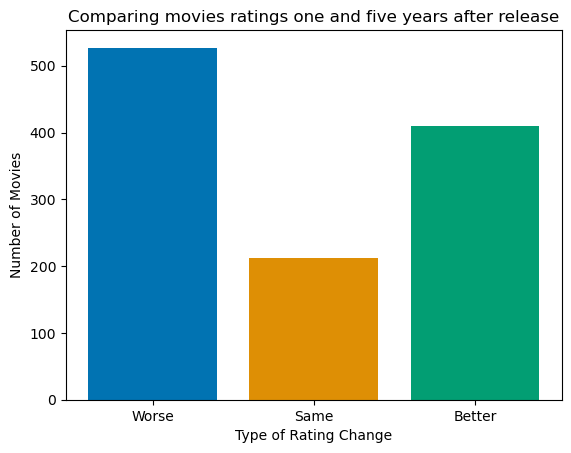

In [22]:
import matplotlib.pyplot as plt

# Assuming you have already calculated ratings_difference
ratings_metadata['ratings_difference'] = ratings_metadata.after_five_year_rating - ratings_metadata.after_one_year_rating

# Count the occurrences of 'worse', 'same', 'better'
count_worse = (ratings_metadata['ratings_difference'] < 0).sum()
count_same = (ratings_metadata['ratings_difference'] == 0).sum()
count_better = (ratings_metadata['ratings_difference'] > 0).sum()

colors = sns.color_palette('colorblind')
plt.bar(['Worse', 'Same', 'Better'], height=[count_worse, count_same, count_better], color=colors)


# Adding labels and title
plt.xlabel('Type of Rating Change')
plt.ylabel('Number of Movies')
plt.title('Comparing movies ratings one and five years after release')

# Show the plot
plt.show()


/tmp/ipykernel_21828/2626963110.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ratings_metadata.fillna(ratings_metadata.mean())
/tmp/ipykernel_21828/2626963110.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ratings_metadata.fillna(ratings_metadata.mean())


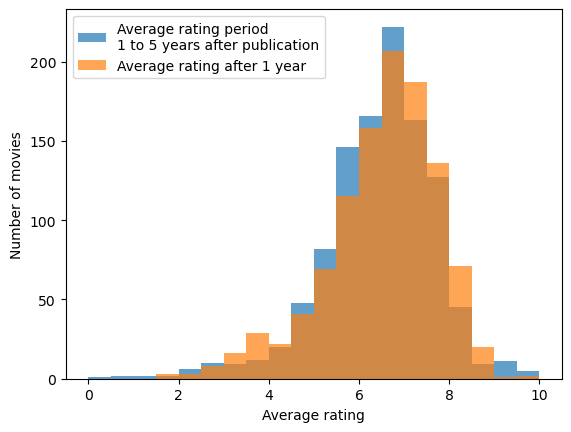

In [23]:
ratings_metadata.fillna(ratings_metadata.mean())

# we'll regres on the average rating in the period from one to five years after publication               
diff_num_voters = ratings_metadata.five_year_num_voters -  ratings_metadata.one_year_num_voters
weigthed_five_years_ratings = ratings_metadata.after_five_year_rating * ratings_metadata.five_year_num_voters
weigthed_one_years_ratings = ratings_metadata.after_one_year_rating * ratings_metadata.one_year_num_voters

# compute the average rating in the period
ratings_metadata['ratings_one_five']  =  (weigthed_five_years_ratings - weigthed_one_years_ratings) / diff_num_voters

# fill missing values
ratings_metadata.ratings_one_five = ratings_metadata.ratings_one_five.fillna(ratings_metadata.ratings_one_five.mean())
ratings_metadata.reset_index(drop=True, inplace=True)

# 
ratings_metadata = ratings_metadata.loc[(ratings_metadata.ratings_one_five != math.inf) & (ratings_metadata.ratings_one_five != -math.inf)]
ratings_metadata = ratings_metadata[(ratings_metadata.ratings_one_five <= 10) & (ratings_metadata.ratings_one_five > 0)]
# plt.hist(ratings_metadata.ratings_one_five, bins = 20, label = 'Average rating period \n1 to 5 years after publication', alpha=0.7)
# plt.hist(ratings_metadata.after_one_year_rating, bins = 20, label = 'Average rating after 1 year', alpha=0.7)

_, bins, _ = plt.hist(ratings_metadata.ratings_one_five, bins=20, range=[0, 10], label = 'Average rating period \n1 to 5 years after publication', alpha = 0.7)
_ = plt.hist(ratings_metadata.after_one_year_rating, bins=bins, alpha=0.7, label = 'Average rating after 1 year')

plt.xlabel('Average rating')
plt.ylabel('Number of movies')
plt.legend()

We can already make some intresting observations. Ratings after one year tend to be slightly higher than the average rating from one to five years. People often have a positive perception of new things, thus it's natural that the recent blockbuster will be more hyped and better reviewed. Things changes one year after the movie's release. 

In [24]:
# Let's do some regression analysis
# df = ratings_metadata[['ratings_one_five' , 'year' , 'after_one_year_rating' , 'runtimeMinutes']].copy()

y = ratings_metadata['ratings_one_five']
X = ratings_metadata.select_dtypes(include=['number'])
X.drop(['ratings_one_five', 'ratings_difference', 'five_year_num_voters', 'after_five_year_rating', 'votes', 'score', 'runtime_x', 'runtime_y'], axis=1, inplace=True)

X = (X - X.mean()) / X.std()
X.fillna(X.mean(), inplace=True)
X = sm.add_constant(X)

# mod = smf.ols(formula='ratings_one_five ~ year + after_one_year_rating + runtimeMinutes + year * after_one_year_rating', data=df)
mod = sm.OLS(y, X)
results = mod.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:       ratings_one_five   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     52.28
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          3.42e-152
Time:                        17:09:08   Log-Likelihood:                -1393.2
No. Observations:                1088   AIC:                             2832.
Df Residuals:                    1065   BIC:                             2947.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     6.43

In this second regression we utilized the average rating from 1 to 5 years that was computed above. The R-square in this case is 0.522, which is acceptable given the complexity of dependent variable we're trying fit. Many features have a high p-value and thus they won't be considered in the analysis of the results. The following are some of the conclusion that can be draws from the regression: 
- The aging of movie (in this case characterize by the average review in the period from one to five year after the release), highly depends on the reviews after one year (p=0.000 t=29.706).
- Adult movies age tend also to age better. 
- Short age worse than others while TV series age better. This makes sense becasuse TV series are trasmitted for a longer period of time, thus in the period from one to five years from when the first episode newer episodes might still be coming out which might have the same effect of a movie release. 

Naturally causation cannot be infered for this, we can only make claims about correlation. 

# Which are the most important features to preict the revenue of a movie? How do they change through the years? 

In [25]:
# load provided dataset 
movies_metadata = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None)
# name columsn based on documentation
movies_metadata.columns = ['wiki id', 'free base id', 'name', 'release date', 'box office revenue', 'runtime', 'languages', 'countries', 'genres']

# parse release date
movies_metadata['release date'] = pd.to_datetime(movies_metadata['release date'], format='%Y-%m-%d', errors='coerce') # convert to datetime format
movies_metadata = movies_metadata.loc[movies_metadata['box office revenue'].notna()].copy() # remove ones without box office revenue
movies_metadata.reset_index(inplace=True, drop=True)

# extracting values from dictionaries 
movies_metadata["genre"] = movies_metadata.apply(lambda row: get_first_value_from_dictionary(row, 'genres'), axis=1)
movies_metadata["language"] = movies_metadata.apply(lambda row: get_first_value_from_dictionary(row, 'languages'), axis=1)
movies_metadata["country"] = movies_metadata.apply(lambda row: get_first_value_from_dictionary(row, 'countries'), axis=1)
movies_metadata['year'] = pd.DatetimeIndex(movies_metadata['release date']).year  # extracting year

# count number of genre, language and countries
movies_metadata["n_genre"] = movies_metadata.apply(lambda row: count_dictionary(row, 'genres'), axis=1)
movies_metadata["n_language"] = movies_metadata.apply(lambda row: count_dictionary(row, 'languages'), axis=1)
movies_metadata["n_country"] = movies_metadata.apply(lambda row: count_dictionary(row, 'countries'), axis=1)

movies_metadata.head(1)

,wiki id,free base id,name,release date,box office revenue,runtime,languages,countries,genres,genre,language,country,year,n_genre,n_language,n_country
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Thriller,English Language,United States of America,2001.0,7,1,1


In [26]:
# this dataset contains the budget and other important features which weren't availible in the original dataset
metadata_df = pd.read_csv('data/movies.csv')

metadata_df.name = metadata_df.name.str.lower()
movies_metadata.name = movies_metadata.name.str.lower()

movies_metadata = movies_metadata.merge(metadata_df, 'inner', on=['name', 'year'])
movies_metadata['name'] = movies_metadata['name'].astype('category').cat.codes
movies_metadata['company'] = movies_metadata['company'].astype('category').cat.codes
movies_metadata['star'] = movies_metadata['star'].astype('category').cat.codes

movies_metadata.head(1)

,wiki id,free base id,name,release date,box office revenue,runtime_x,languages,countries,genres,genre_x,...,score,votes,director,writer,star,country_y,budget,gross,company,runtime_y
0,975900,/m/03vyhn,1317,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Thriller,...,4.9,52000.0,John Carpenter,Larry Sulkis,1124,United States,28000000.0,14010832.0,1038,98.0


In [27]:
# adjust budget by inflation, dataset taken from https://fred.stlouisfed.org/series/CPIAUCSL
cpi_over_time = pd.read_csv('data/CPIAUCSL.csv')
# compute the inflation rate for every year compared to today
cpi_over_time['adjustment'] = cpi_over_time['CPIAUCSL'].iloc[-1] / cpi_over_time['CPIAUCSL']  
cpi_over_time['date'] = pd.to_datetime(cpi_over_time.DATE, utc=True)
cpi_over_time['year'] = cpi_over_time['date'].apply(lambda x : x.year)
# group the inflation rate per year
cpi_over_time = cpi_over_time.groupby('year').mean()

# merge with previously loaded dataset
importance_over_time_df_adjusted = movies_metadata.merge(cpi_over_time, 'inner', on='year').copy()
# multiply the budget by inflation rate in order to get inflation adjusted budget
importance_over_time_df_adjusted['adjusted_budget'] = importance_over_time_df_adjusted.adjustment *  importance_over_time_df_adjusted.budget
# same for box office revenue
importance_over_time_df_adjusted['adjusted_box_office_revenue'] = importance_over_time_df_adjusted.adjustment *  importance_over_time_df_adjusted['box office revenue']

importance_over_time_df_adjusted = importance_over_time_df_adjusted.merge(movie_stats, 'inner', left_on='free base id', right_on='Freebase Movie ID')
importance_over_time_df_adjusted.head(1)

,wiki id,free base id,name,release date,box office revenue,runtime_x,languages,countries,genres,genre_x,...,company,runtime_y,CPIAUCSL,adjustment,adjusted_budget,adjusted_box_office_revenue,Freebase Movie ID,num_actors,avg_age,gender_percent
0,975900,/m/03vyhn,1317,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Thriller,...,1038,98.0,177.041667,1.737584,4.865235e+07,2.434499e+07,/m/03vyhn,17,43.461538,35.294118


In [28]:
from datetime import * 

# divide dates in group of roughly two years each
days_range = 700

start_range = datetime(1920, 1, 1)
end_range = datetime(1920, 1, 1) + timedelta(days_range)
max_date = importance_over_time_df_adjusted['release date'].max()

# only keep movies after 1920
fixed_release_date = importance_over_time_df_adjusted.loc[importance_over_time_df_adjusted['release date'] >= start_range].copy(deep = True)

# assign value year for all movies between year and year + timedelta 700 days
while start_range < max_date: 
    fixed_release_date.loc[(fixed_release_date['release date'] >= start_range) &
                                 (fixed_release_date['release date'] < end_range), ('release date')]  = start_range
    start_range = end_range
    end_range = end_range + timedelta(days_range)

In [29]:
# these are the features we have so far for this section
fixed_release_date.columns

Index(['wiki id', 'free base id', 'name', 'release date', 'box office revenue',
       'runtime_x', 'languages', 'countries', 'genres', 'genre_x', 'language',
       'country_x', 'year', 'n_genre', 'n_language', 'n_country', 'rating',
       'genre_y', 'released', 'score', 'votes', 'director', 'writer', 'star',
       'country_y', 'budget', 'gross', 'company', 'runtime_y', 'CPIAUCSL',
       'adjustment', 'adjusted_budget', 'adjusted_box_office_revenue',
       'Freebase Movie ID', 'num_actors', 'avg_age', 'gender_percent'],
      dtype='object')

The initial idea was to find which were the most relevant feature for predicting the box office revenue through the years. The only feature which reliably had a significant coefficient was the budget, so we limited our analysis to that. One interesting thing which can be concluded from the plots is that only after 2004 the budget gained a significant influence on the box office revenue, before the influence wasn't significant. To futher confirm that below are reported two regression, one on movies before 2004 and the other with movies after 2004. In the regression on the dataset year < 2004 we foudn a low R-square = 0.242, while on the dataset with year > 2004 R-quare = 0.538. This indicates that the correlation between budget and box office revenue became stronger in recent years (as the budget can explain more variance). Of course we can't conclude causation from this as there might be unmeasured counfouders. 

In [30]:
y = fixed_release_date[fixed_release_date.year < 2004].adjusted_box_office_revenue
df = fixed_release_date[fixed_release_date.year < 2004].adjusted_budget
df.fillna(df.mean(), inplace=True)
df = (df - df.mean()) / df.std()
df = sm.add_constant(df)

model = sm.OLS(y, df.astype(float))
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:     adjusted_box_office_revenue   R-squared:                       0.242
Model:                                     OLS   Adj. R-squared:                  0.242
Method:                          Least Squares   F-statistic:                     970.9
Date:                         Fri, 22 Dec 2023   Prob (F-statistic):          3.61e-185
Time:                                 17:09:24   Log-Likelihood:                -62110.
No. Observations:                         3035   AIC:                         1.242e+05
Df Residuals:                             3033   BIC:                         1.242e+05
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

/tmp/ipykernel_21828/3432583134.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)


In [31]:
y = fixed_release_date[fixed_release_date.year > 2004].adjusted_box_office_revenue
df = fixed_release_date[fixed_release_date.year > 2004].adjusted_budget
df.fillna(df.mean(), inplace=True)
df = (df - df.mean()) / df.std()
df = sm.add_constant(df)

model = sm.OLS(y, df.astype(float))
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:     adjusted_box_office_revenue   R-squared:                       0.538
Model:                                     OLS   Adj. R-squared:                  0.538
Method:                          Least Squares   F-statistic:                     1411.
Date:                         Fri, 22 Dec 2023   Prob (F-statistic):          2.22e-205
Time:                                 17:09:25   Log-Likelihood:                -24782.
No. Observations:                         1213   AIC:                         4.957e+04
Df Residuals:                             1211   BIC:                         4.958e+04
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

/tmp/ipykernel_21828/745455514.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)


Firstly from the two regression above we noticed that we were able to fit the box office just from the budget much better movies after 2004 than movies before 2004. This hinted at the fact that budget became a much more important feature in recent years. Below we have reported the regression line with the outlier highlighted. We can conclude while before 2004 it was possible to make a successfull movie even with a low budget (there are many outliers with low budget and high box office reveneu) around 2004 there was a shift in how movies where produced and the budget became crucial for the success of the movie. 

/tmp/ipykernel_21828/2344131101.py:9: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  after.fillna(after.mean(), inplace=True)
/tmp/ipykernel_21828/2344131101.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after.fillna(after.mean(), inplace=True)
/tmp/ipykernel_21828/2344131101.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after.fillna(after.mean(), inplace=True)
/tmp/ipykernel_21828/2344131101.py:34: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=Non

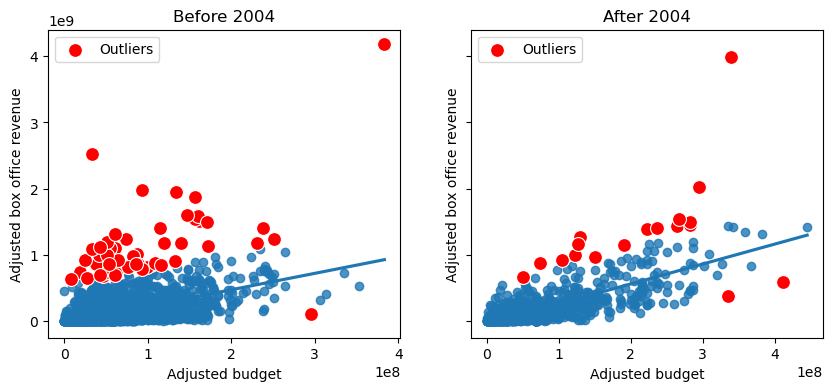

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

f, axes = plt.subplots(1, 2, sharey=True, figsize= (10, 4))


after = fixed_release_date[fixed_release_date['year'] < 2004]
after.fillna(after.mean(), inplace=True)

# Create a regression plot
reg_plot = sns.regplot(data=after, x='adjusted_budget', y='adjusted_box_office_revenue', ci=None, ax = axes[0])

# Get the regression line parameters
slope, intercept = np.polyfit(after['adjusted_budget'], after['adjusted_box_office_revenue'], 1)

# Calculate residuals
residuals = after['adjusted_box_office_revenue'] - (intercept + slope * after['adjusted_budget'])

# Identify points further than one standard deviation from the regression line
outliers = after[np.abs(residuals) > 3*np.std(residuals)]

# Highlight outliers in red with 'x' markers
sns.scatterplot(x='adjusted_budget', y='adjusted_box_office_revenue', data=outliers, color='red', s=100, label='Outliers', ax = axes[0])

axes[0].legend()
axes[0].set_title('Before 2004')
axes[0].set_xlabel('Adjusted budget')
axes[0].set_ylabel('Adjusted box office revenue')
# plt.show()

# Assuming you have a DataFrame named 'fixed_release_date'
after = fixed_release_date[fixed_release_date['year'] > 2004]
after.fillna(after.mean(), inplace=True)

# Create a regression plot
reg_plot = sns.regplot(data=after, x='adjusted_budget', y='adjusted_box_office_revenue', ci=None, ax = axes[1])

# Get the regression line parameters
slope, intercept = np.polyfit(after['adjusted_budget'], after['adjusted_box_office_revenue'], 1)

# Calculate residuals
residuals = after['adjusted_box_office_revenue'] - (intercept + slope * after['adjusted_budget'])

# Identify points further than one standard deviation from the regression line
outliers = after[np.abs(residuals) > 3*np.std(residuals)]

# Highlight outliers in red with 'x' markers
sns.scatterplot(x='adjusted_budget', y='adjusted_box_office_revenue', data=outliers, color='red', s=100, label='Outliers', ax = axes[1])

# plt.legend(loc='upper left')
axes[1].set_title('After 2004')
axes[1].set_xlabel('Adjusted budget')
axes[1].set_ylabel('Adjusted box office revenue')
plt.show()
